# 3. Fitting diads once you have groups
- Once you have divided your diads into groups based on strengths, you need to tweak the fit parameters for each group
- Then you can loop through all files in a given group and automatically fit the spectra

In [32]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import joblib
import DiadFit as pf
pf.__version__

'0.0.69dev'

## Specifying filetype, and folder as before

In [33]:
# This specifies what file type your Raman exported in. 
meta_path, spectra_path, filetype, prefix, prefix_str, file_ext, TruPower=pf.get_settings()

## Load in data and fit parameters
- This loads in the dataframes of the fit parameters you saved in the other file, by group
- At this point you select what group you want to fit (batch = 'Weak', 'Medium' or 'Strong'). After running through the entire notebook for one group, come back up here to fit a second group.

In [34]:

# Select the group you want to fit ('Weak', 'Medium', 'Strong')
batch='Medium' # Options are Weak, Medium, Strong

if batch=='Weak':
    GroupN_df=joblib.load('Weak_df.sav')
if batch=='Medium':
    GroupN_df=joblib.load('Medium_df.sav')
if batch=='Strong':
    GroupN_df=joblib.load('Strong_df.sav')

### Now load one file from this group to tweak parameters for

In [35]:
Diad_Files =GroupN_df['filename']
i=0


### Lets plot the diad to have a look at it

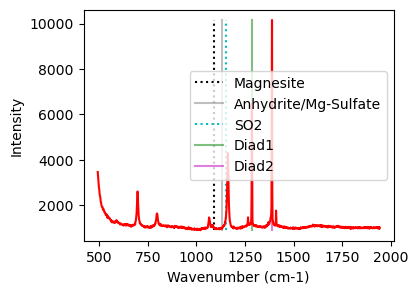

In [36]:
plot1=pf.plot_diad(path=spectra_path, filename=Diad_Files[i], filetype=filetype)

## Now lets inspect the diads and get their approximate positions
- As with generic peak, you can exclude 2 segments (e.g. around cosmic rays)
- You then specify how many peaks you want to fit on each diad. 1 means just the strong peak, 2 hotbands, and 3 for Diad2 would also fit the C13 peak if present. 
- The identify_diad_peaks then uses scipy findpeaks to identify the positions of the 2 diads, and any other peaks the user asks for. These are saved, and fed into the later functions for peak fitting. 

## Choose a model for fitting all peaks
- Option of Voigt or PseudoVoigt. We recomend PsuedoVoigt

In [37]:
model_name='PseudoVoigtModel'

## Fit Diad 1
- Tweak the parameters in the config files for each group. E.g. how many peaks (fit_peaks), the background positions, the sigma of the diad, and whether or not you want a gaussian background

In [46]:
diad_id_config=pf.diad_id_config(height=50, exclude_range1=[1308, 1309])
diad_id_config

if batch=='Weak':
    diad1_fit_config_init=pf.diad1_fit_config(
    model_name=model_name, fit_peaks=1,
    N_poly_bck_diad1=2, lower_bck_diad1=(1250, 1275),
    upper_bck_diad1=(1300, 1350),
    diad_sigma=1.1,
    x_range_residual=10, x_range_baseline=30, 
     y_range_baseline=1000, 
    HB_prom=GroupN_df['HB1_abs_prom'].iloc[i], 
    diad_prom=GroupN_df['Diad1_abs_prom'].iloc[i])
    diad1_fit_config_init


if batch=='Medium':
    diad1_fit_config_init=pf.diad1_fit_config(
    model_name=model_name, fit_peaks=2,
    N_poly_bck_diad1=1, lower_bck_diad1=(1180, 1220),
    upper_bck_diad1=(1330, 1350),
    diad_sigma=0.6,
    x_range_residual=10, x_range_baseline=30, 
     y_range_baseline=100, 
    HB_prom=GroupN_df['HB1_abs_prom'].iloc[i], 
    diad_prom=GroupN_df['Diad1_abs_prom'].iloc[i])
    diad1_fit_config_init

if batch=='Strong':
    diad1_fit_config_init=pf.diad1_fit_config(
    fit_gauss=True, gauss_amp= 2*GroupN_df['HB1_abs_prom'].iloc[i],
    model_name=model_name, fit_peaks=2,
    N_poly_bck_diad1=1, lower_bck_diad1=(1180, 1220),
    upper_bck_diad1=(1330, 1350),
    diad_sigma=0.6,
    x_range_residual=10, x_range_baseline=30, 
     y_range_baseline=1000, 
    HB_prom=GroupN_df['HB1_abs_prom'].iloc[i], 
    diad_prom=GroupN_df['Diad1_abs_prom'].iloc[i])
diad1_fit_config_init

diad1_fit_config(model_name='PseudoVoigtModel', fit_peaks=2, N_poly_bck_diad1=1, lower_bck_diad1=(1180, 1220), upper_bck_diad1=(1330, 1350), fit_gauss=False, gauss_amp=1000, diad_sigma=0.6, diad_sigma_min_allowance=0.2, diad_sigma_max_allowance=5, diad_prom=3528.1646121419, HB_prom=331.02149516739007, x_range_baseline=30, y_range_baseline=100, dpi=200, x_range_residual=10, return_other_params=False)

### See what these fit parameters look like for diad1

Diad1_Combofit_Cent  Diad1_Voigt_Cent  Diad1_cent_err  Diad1_Voigt_Area  \
0          1285.527243       1285.527393         0.01196      16331.185944   

   Diad1_Voigt_Sigma  Diad1_Voigt_Gamma    HB1_Cent     HB1_Area  HB1_Sigma  \
0           1.108174                  0  1265.51103  3314.746006   3.307731   

   Diad1_Combofit_Height  Diad1_Residual  Diad1_Prop_Lor  Diad1_fwhm  \
0            5621.251139        35.64134        0.586865    2.216349   

         Diad1_refit  
0  Flagged Warnings:

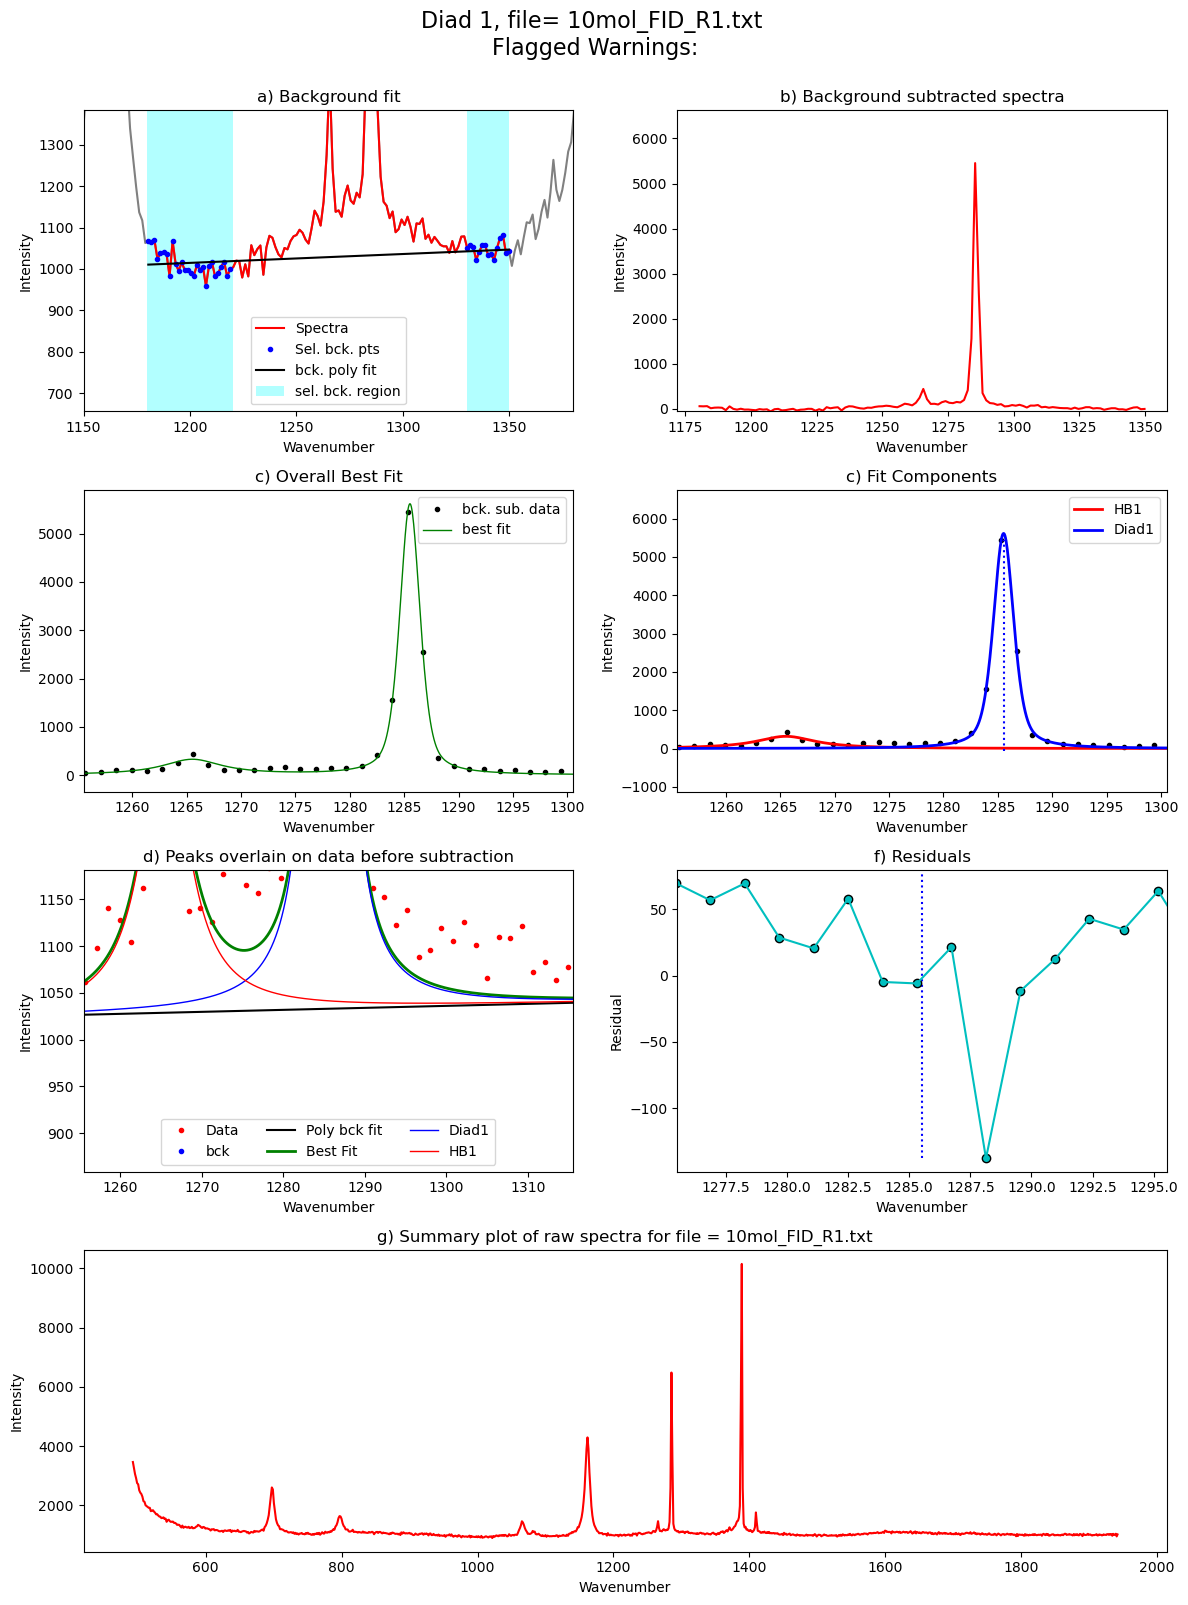

In [47]:
Diad1_fit=pf.fit_diad_1_w_bck(config1=diad1_fit_config_init,
config2=diad_id_config,
path=spectra_path, filename=Diad_Files.iloc[0],
filetype=filetype, plot_figure=True, close_figure=False,
Diad_pos=GroupN_df['Diad1_pos'].iloc[i],
HB_pos=GroupN_df['HB1_pos'].iloc[i])
Diad1_fit

### Update the sigma
- The sigma parameter varies quite a lot based on the splitting. Best to update your first guess with what you found for the example file above

In [40]:
diad1_fit_config2=diad1_fit_config_init

## Fit diad2

In [48]:
if batch=='Weak':
    diad2_fit_config_init=pf.diad2_fit_config(model_name=model_name,
    fit_peaks=1, upper_bck_diad2=(1393, 1399),
    lower_bck_diad2=(1378, 1384), diad_sigma=1,  N_poly_bck_diad2=1,                                       
    x_range_residual=30, y_range_baseline=1000,  
    x_range_baseline=30,
    HB_prom=GroupN_df['HB2_abs_prom'].iloc[i], 
    diad_prom=GroupN_df['Diad2_abs_prom'].iloc[i])
    diad2_fit_config_init

if batch=='Medium':
    diad2_fit_config_init=pf.diad2_fit_config(model_name=model_name,
    fit_peaks=2,
    lower_bck_diad2=(1310, 1340), diad_sigma=1,  N_poly_bck_diad2=1,                                       
    x_range_residual=30, y_range_baseline=1000,  
    x_range_baseline=30,
    HB_prom=GroupN_df['HB2_abs_prom'].iloc[i], 
    diad_prom=GroupN_df['Diad2_abs_prom'].iloc[i],
    C13_prom=GroupN_df['C13_abs_prom'].iloc[i])
    diad2_fit_config_init

if batch=='Strong':
    diad2_fit_config_init=pf.diad2_fit_config(model_name=model_name,
    fit_peaks=3, fit_gauss=True, gauss_amp= 2*GroupN_df['HB2_abs_prom'].iloc[i],
    lower_bck_diad2=(1310, 1340), diad_sigma=1,  N_poly_bck_diad2=2,                                       
    x_range_residual=30, y_range_baseline=1000,  
    x_range_baseline=30,
    HB_prom=GroupN_df['HB2_abs_prom'].iloc[i], 
    diad_prom=GroupN_df['Diad2_abs_prom'].iloc[i],
    C13_prom=GroupN_df['C13_abs_prom'].iloc[i])
    diad2_fit_config_init
diad2_fit_config_init

diad2_fit_config(model_name='PseudoVoigtModel', fit_peaks=2, N_poly_bck_diad2=1, lower_bck_diad2=(1310, 1340), upper_bck_diad2=(1440, 1470), fit_gauss=False, gauss_amp=1000, diad_sigma=1, diad_sigma_min_allowance=0.2, diad_sigma_max_allowance=5, diad_prom=6262.704346261276, HB_prom=545.3112710719574, x_range_baseline=30, y_range_baseline=1000, plot_figure=True, dpi=200, x_range_residual=30, return_other_params=False, C13_prom=96.37652917966761)

### See what these fit parameters look like for diad2

Diad2_Combofit_Cent  Diad2_Voigt_Cent  Diad2_cent_err  Diad2_Voigt_Area  \
0          1388.571043       1388.570993        0.016041      17479.641834   

   Diad2_Voigt_Sigma  Diad2_Voigt_Gamma     HB2_Cent     HB2_Area  HB2_Sigma  \
0           0.931122                  0  1409.960262  2236.302481   1.303649   

   Diad2_Combofit_Height  Diad2_Residual  Diad2_Prop_Lor  Diad2_fwhm  \
0            6558.270965       37.641135        0.795687    1.862245   

         Diad2_refit  
0  Flagged Warnings:

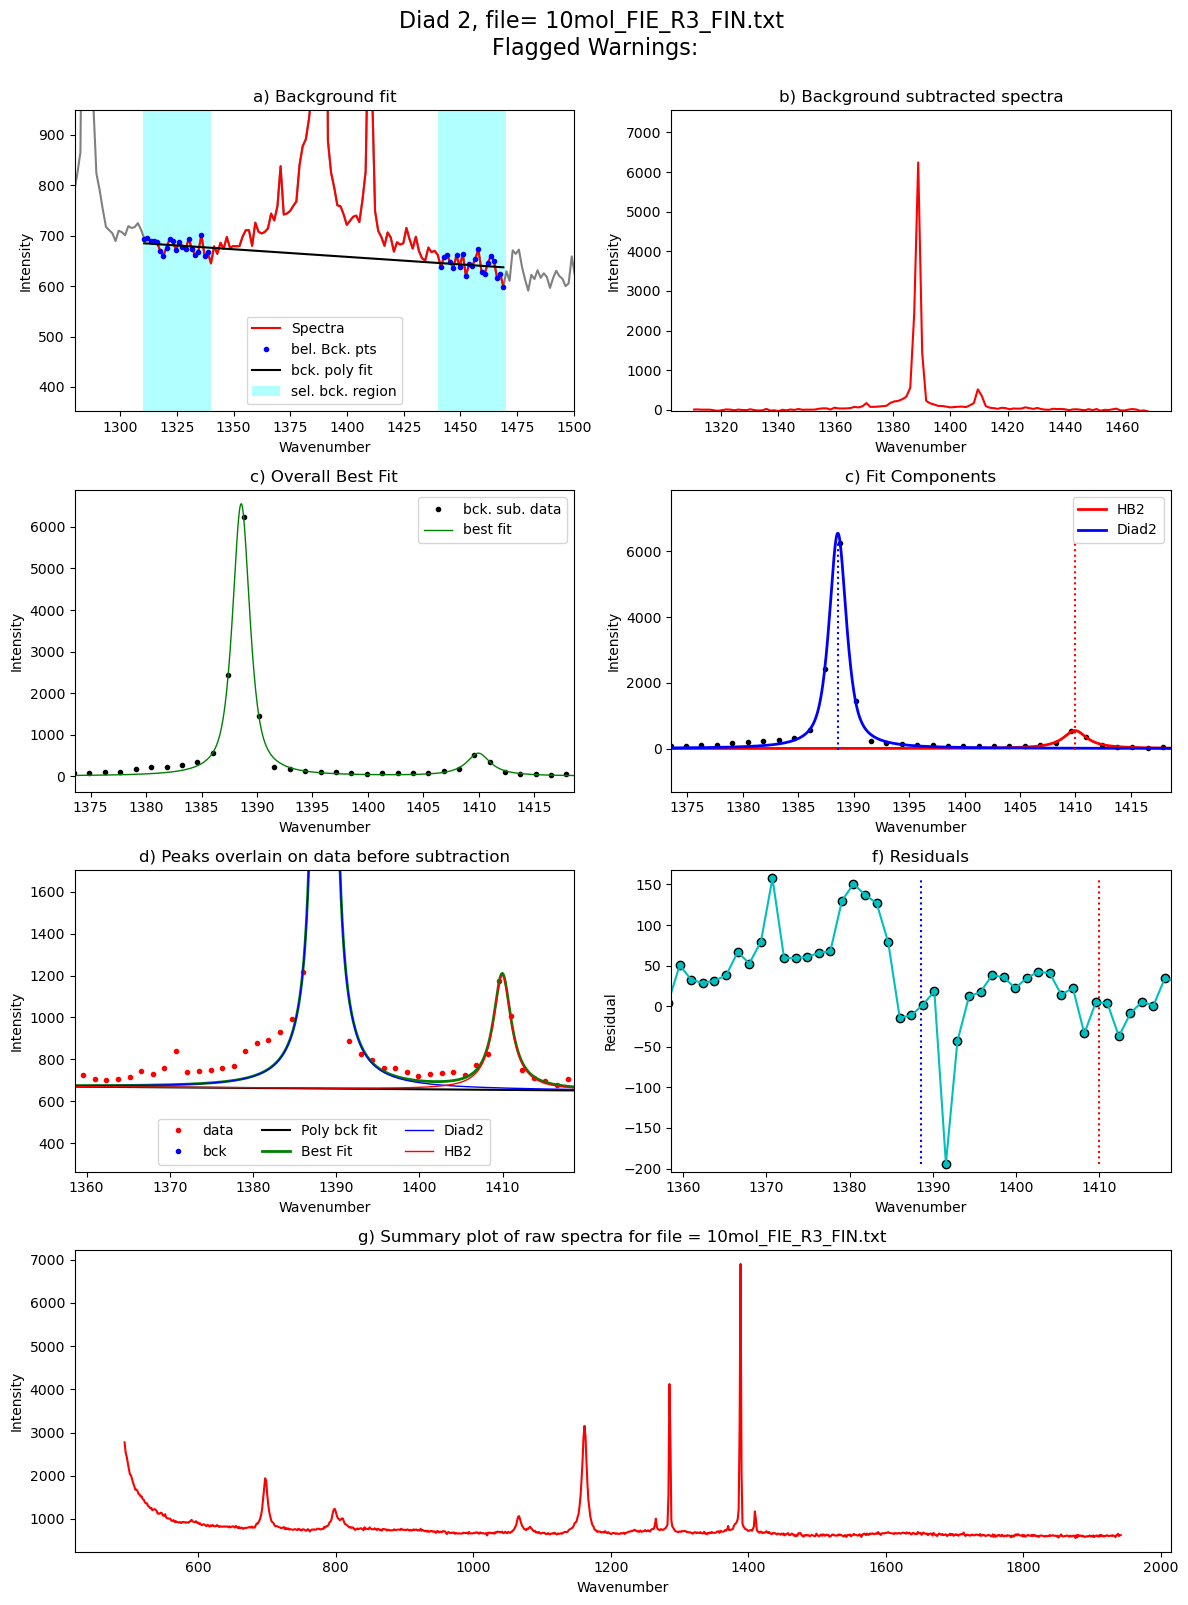

In [49]:
Diad2_fit=pf.fit_diad_2_w_bck(config1=diad2_fit_config_init,
    config2=diad_id_config,
path=spectra_path, filename=Diad_Files[i], filetype=filetype,
plot_figure=True, close_figure=False, 
Diad_pos=GroupN_df['Diad2_pos'].iloc[i],
HB_pos=GroupN_df['HB2_pos'].iloc[i], 
C13_pos=GroupN_df['C13_pos'].iloc[i])
Diad2_fit.to_clipboard(excel=True)
Diad2_fit

## Loop over all the files in the group
- This will loop over all the 

  0%|          | 0/11 [00:00<?, ?it/s]

Processing file: 10mol_FID_R1.txt


  9%|▉         | 1/11 [00:05<00:59,  5.93s/it]

Processing file: 10mol_FID_R1_FIN.txt


 18%|█▊        | 2/11 [00:11<00:52,  5.85s/it]

Processing file: 10mol_FID_R2.txt


 27%|██▋       | 3/11 [00:16<00:43,  5.38s/it]

Processing file: 10mol_FID_R2_FIN.txt


 36%|███▋      | 4/11 [00:19<00:31,  4.48s/it]

Processing file: 10mol_FID_R3.txt


 45%|████▌     | 5/11 [00:22<00:23,  3.94s/it]

Processing file: 10mol_FID_R3_FIN.txt


 55%|█████▍    | 6/11 [00:25<00:18,  3.66s/it]

Processing file: 10mol_FIE_R1.txt


 64%|██████▎   | 7/11 [00:29<00:14,  3.57s/it]

Processing file: 10mol_FIE_R1_FIN.txt


 73%|███████▎  | 8/11 [00:32<00:10,  3.45s/it]

Processing file: 10mol_FIE_R2.txt


 82%|████████▏ | 9/11 [00:35<00:06,  3.47s/it]

Processing file: 10mol_FIE_R2_FIN.txt


 91%|█████████ | 10/11 [00:39<00:03,  3.52s/it]

Processing file: 10mol_FIE_R3_FIN.txt


g:\my drive\berkeley_new\diadfit_outer\src\DiadFit\diads.py:2969: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig,axes=plt.subplot_mosaic(mosaic=figure_mosaic, figsize=(12, 16))
100%|██████████| 11/11 [00:42<00:00,  3.90s/it]


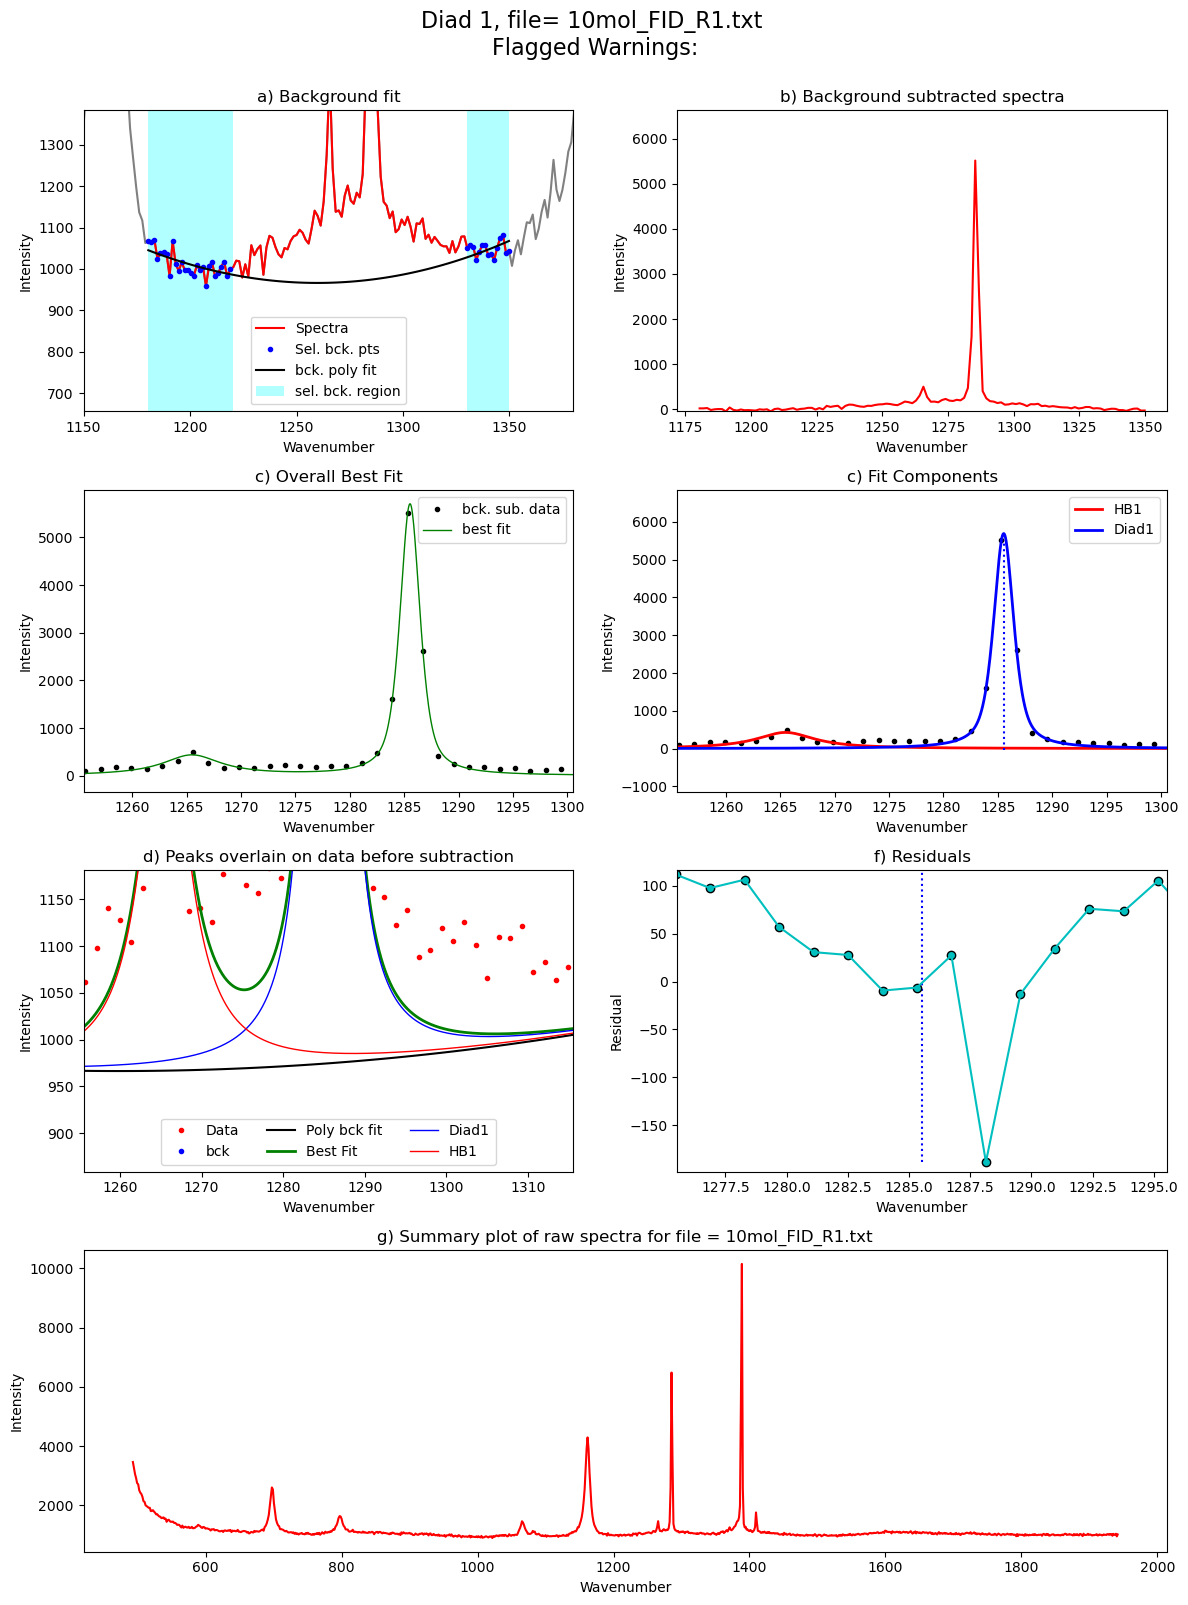

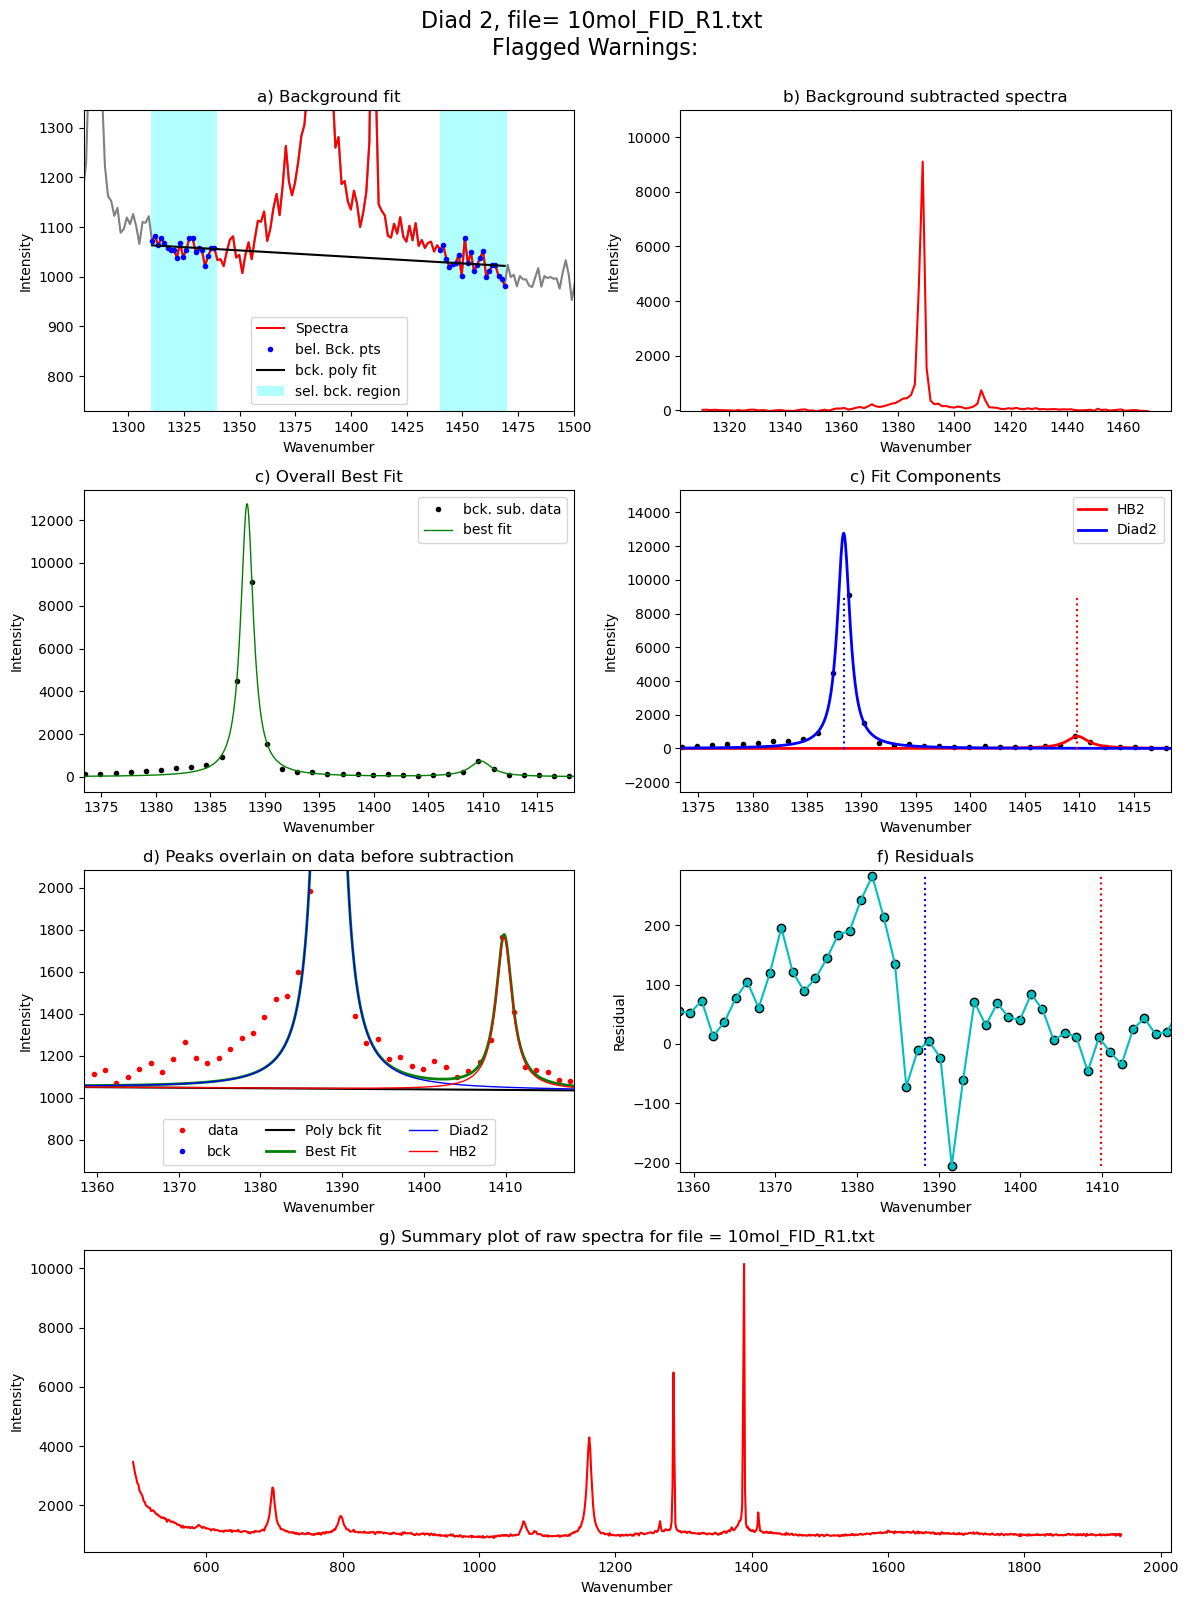

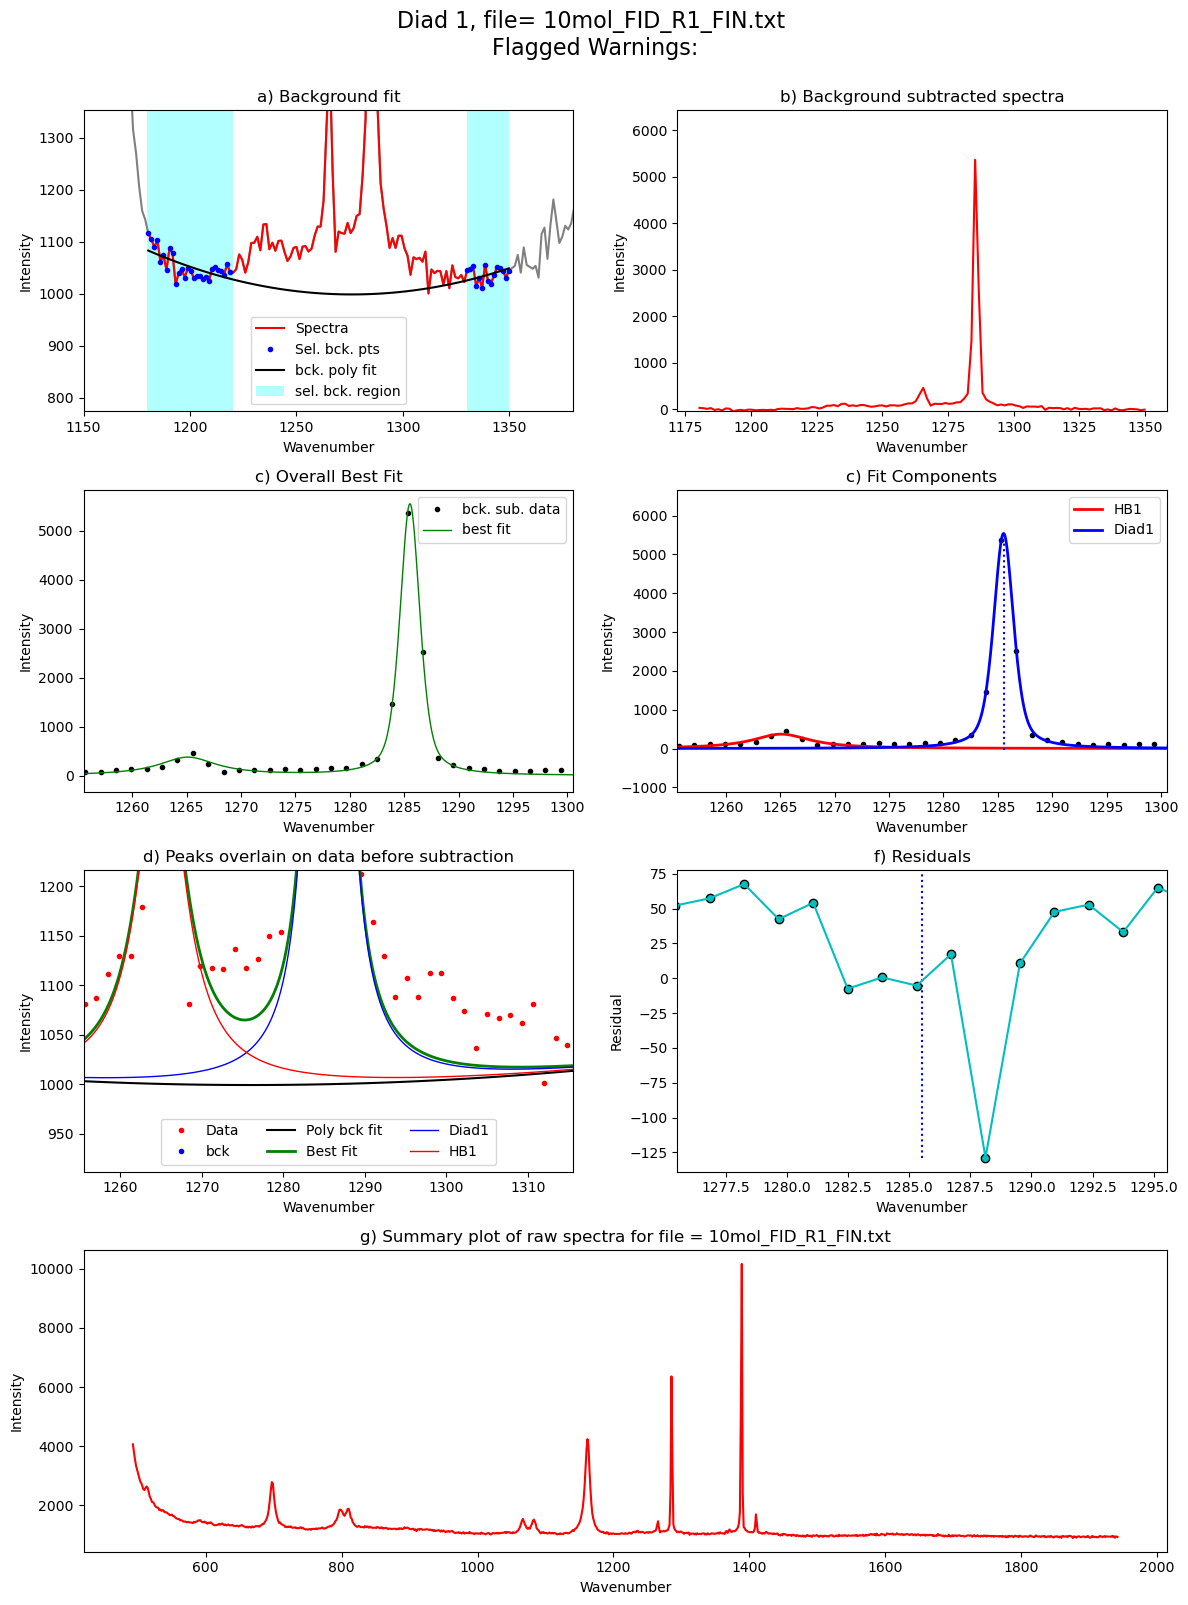

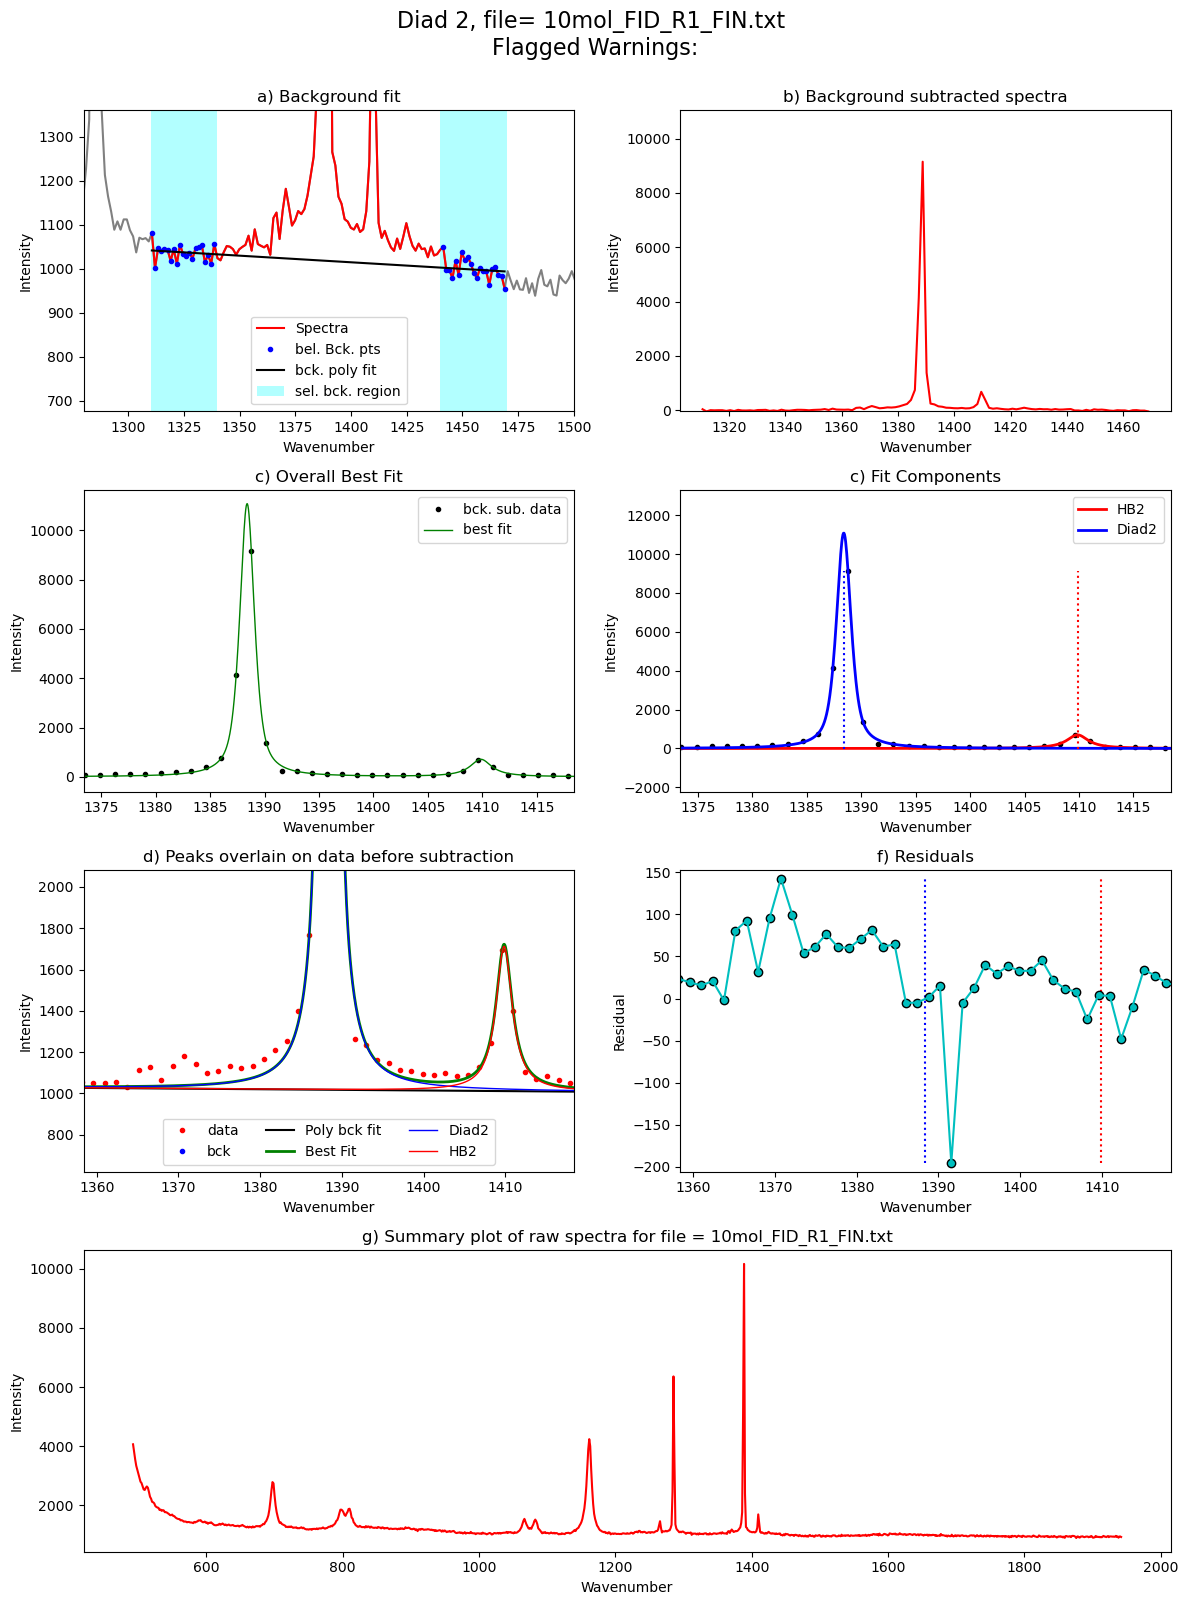

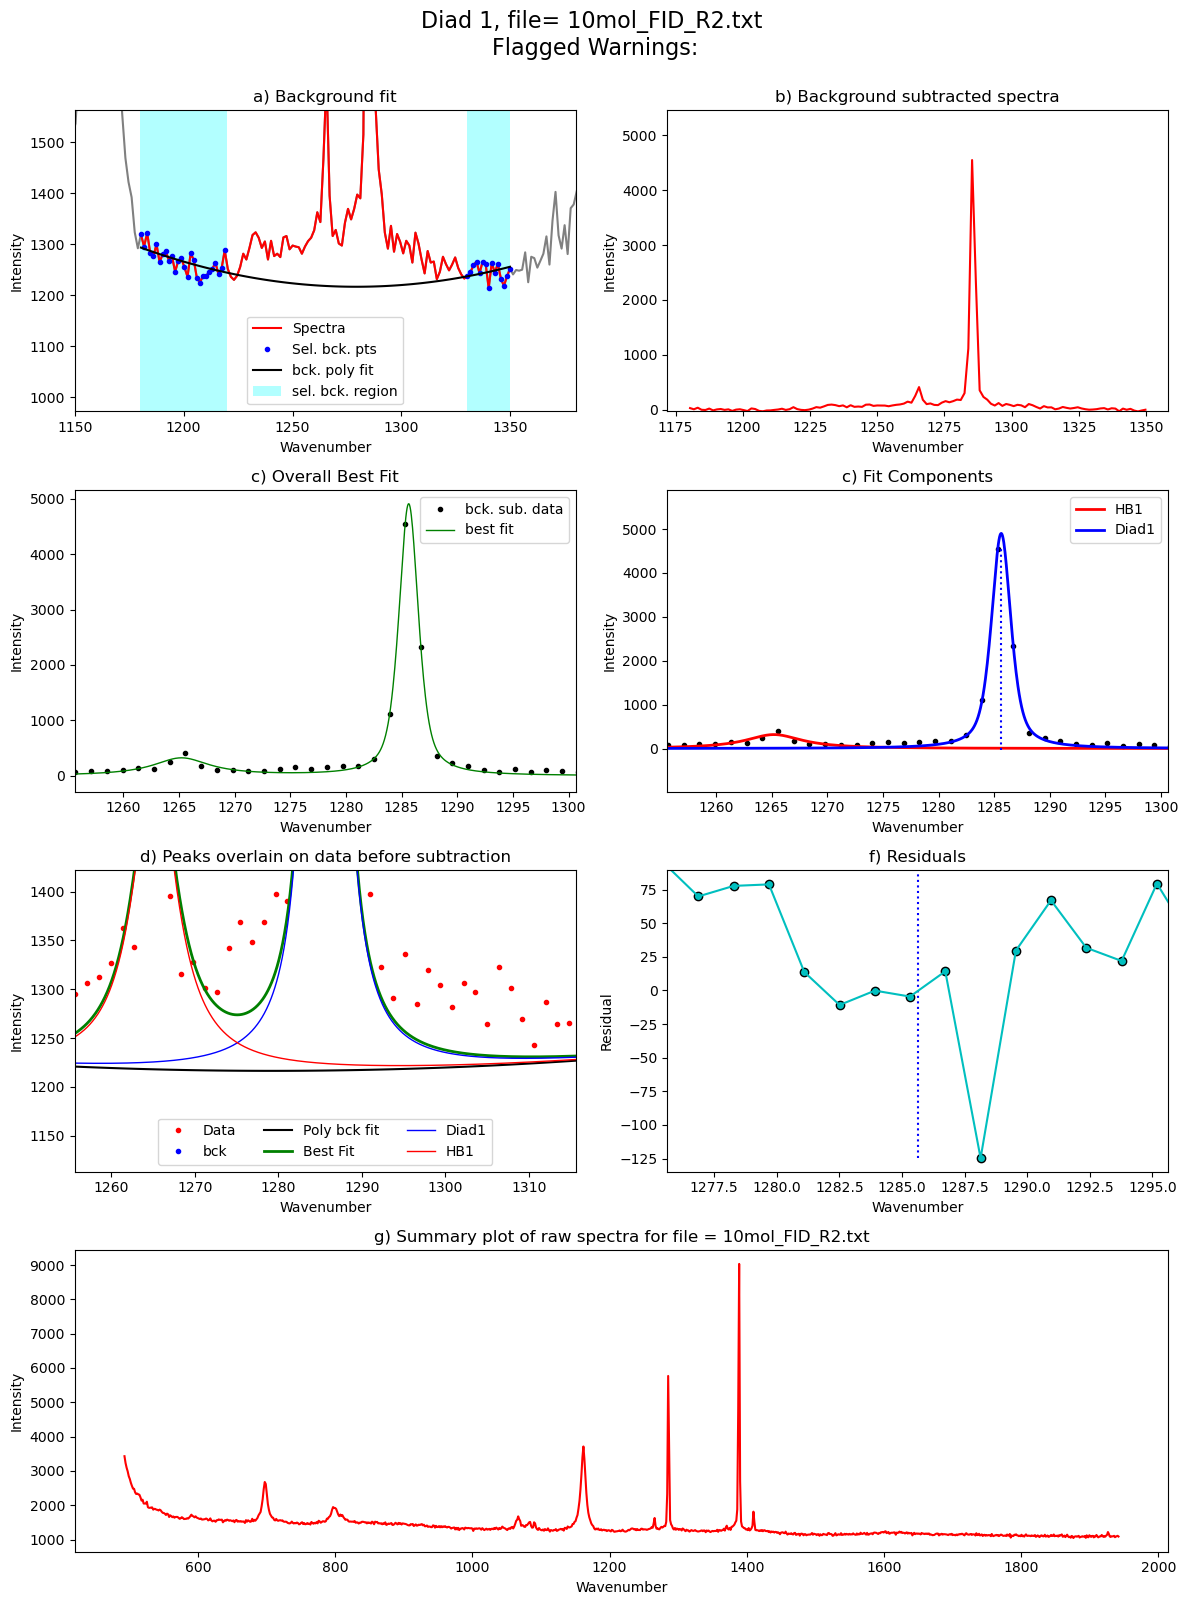

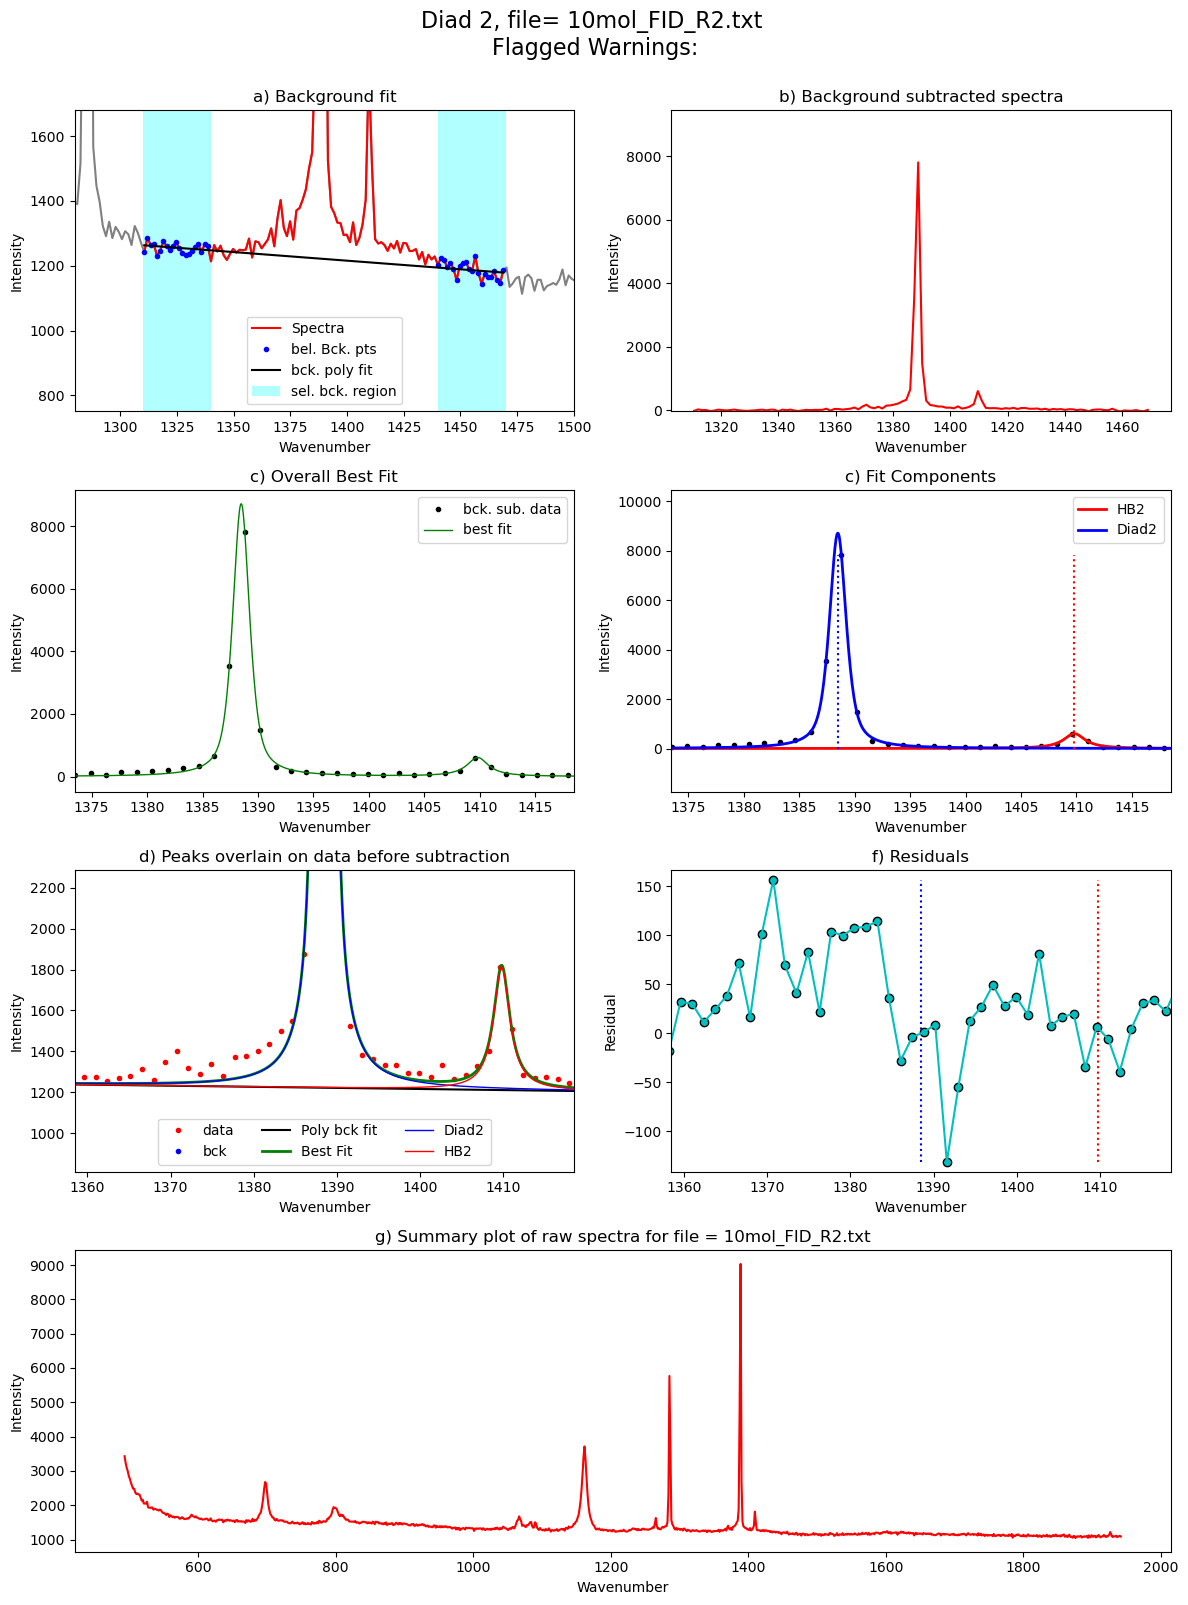

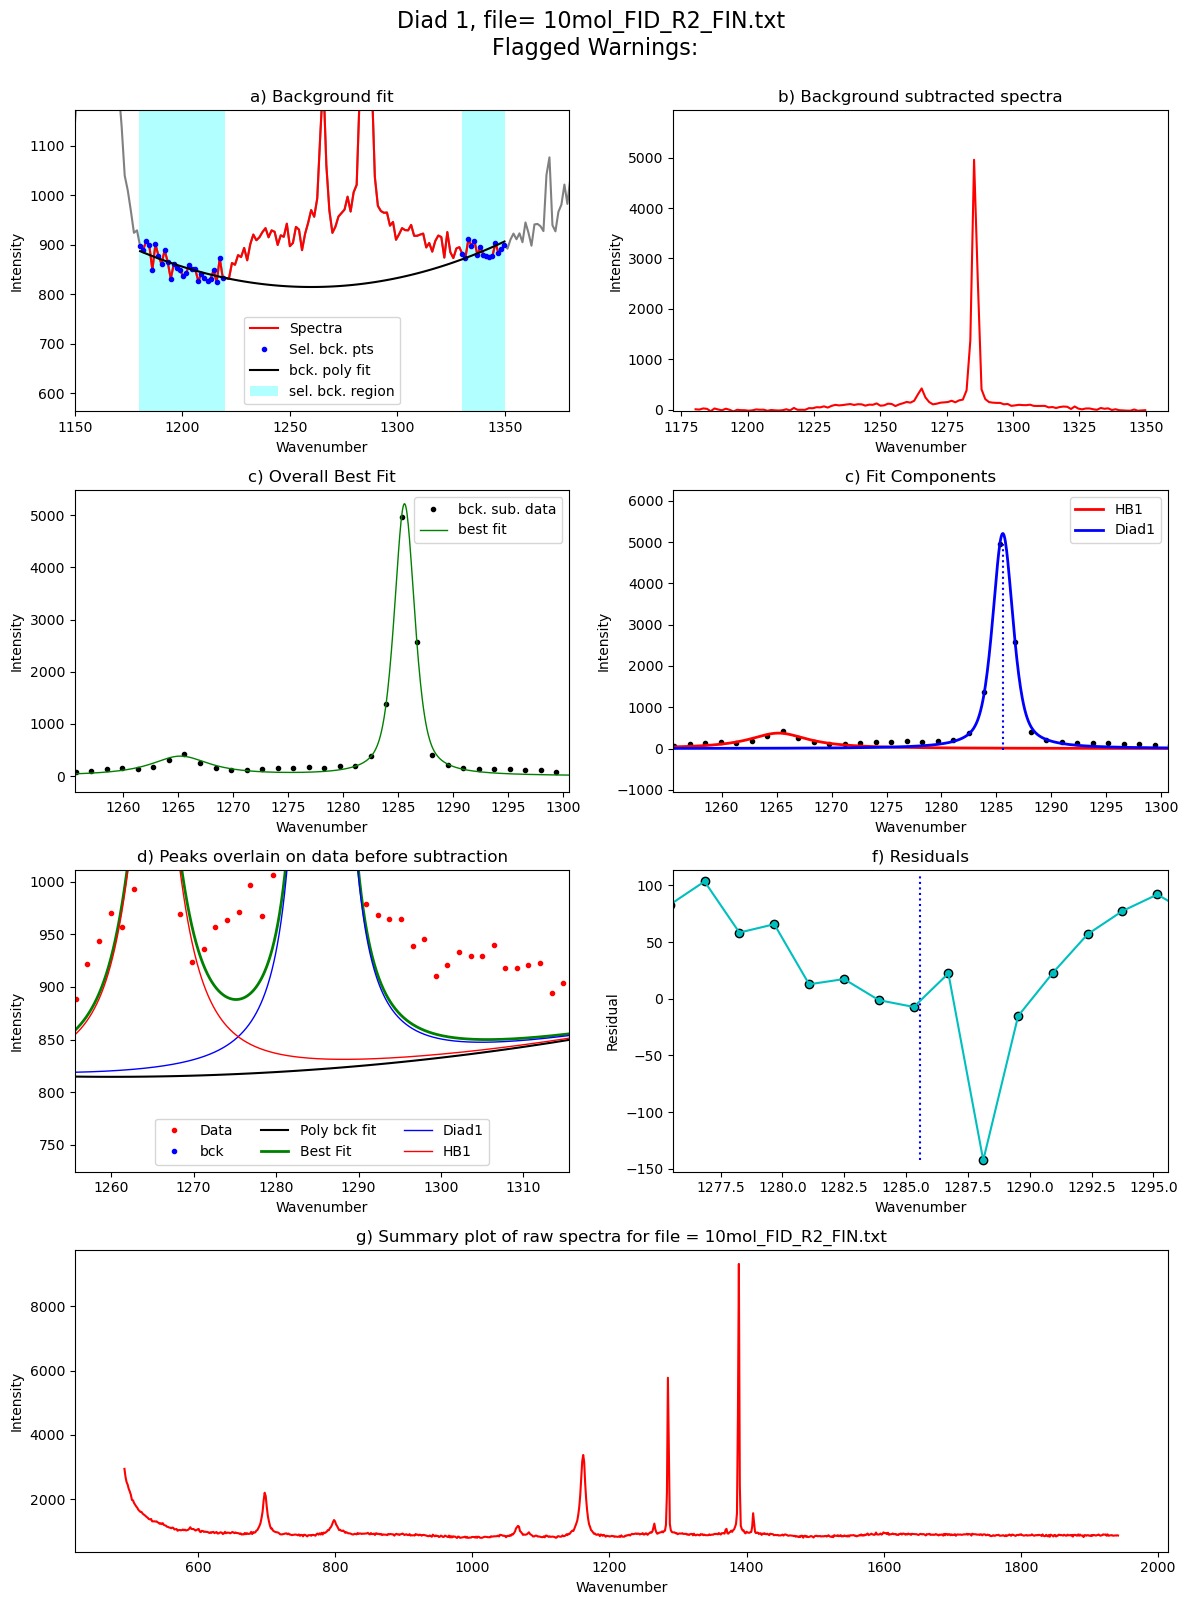

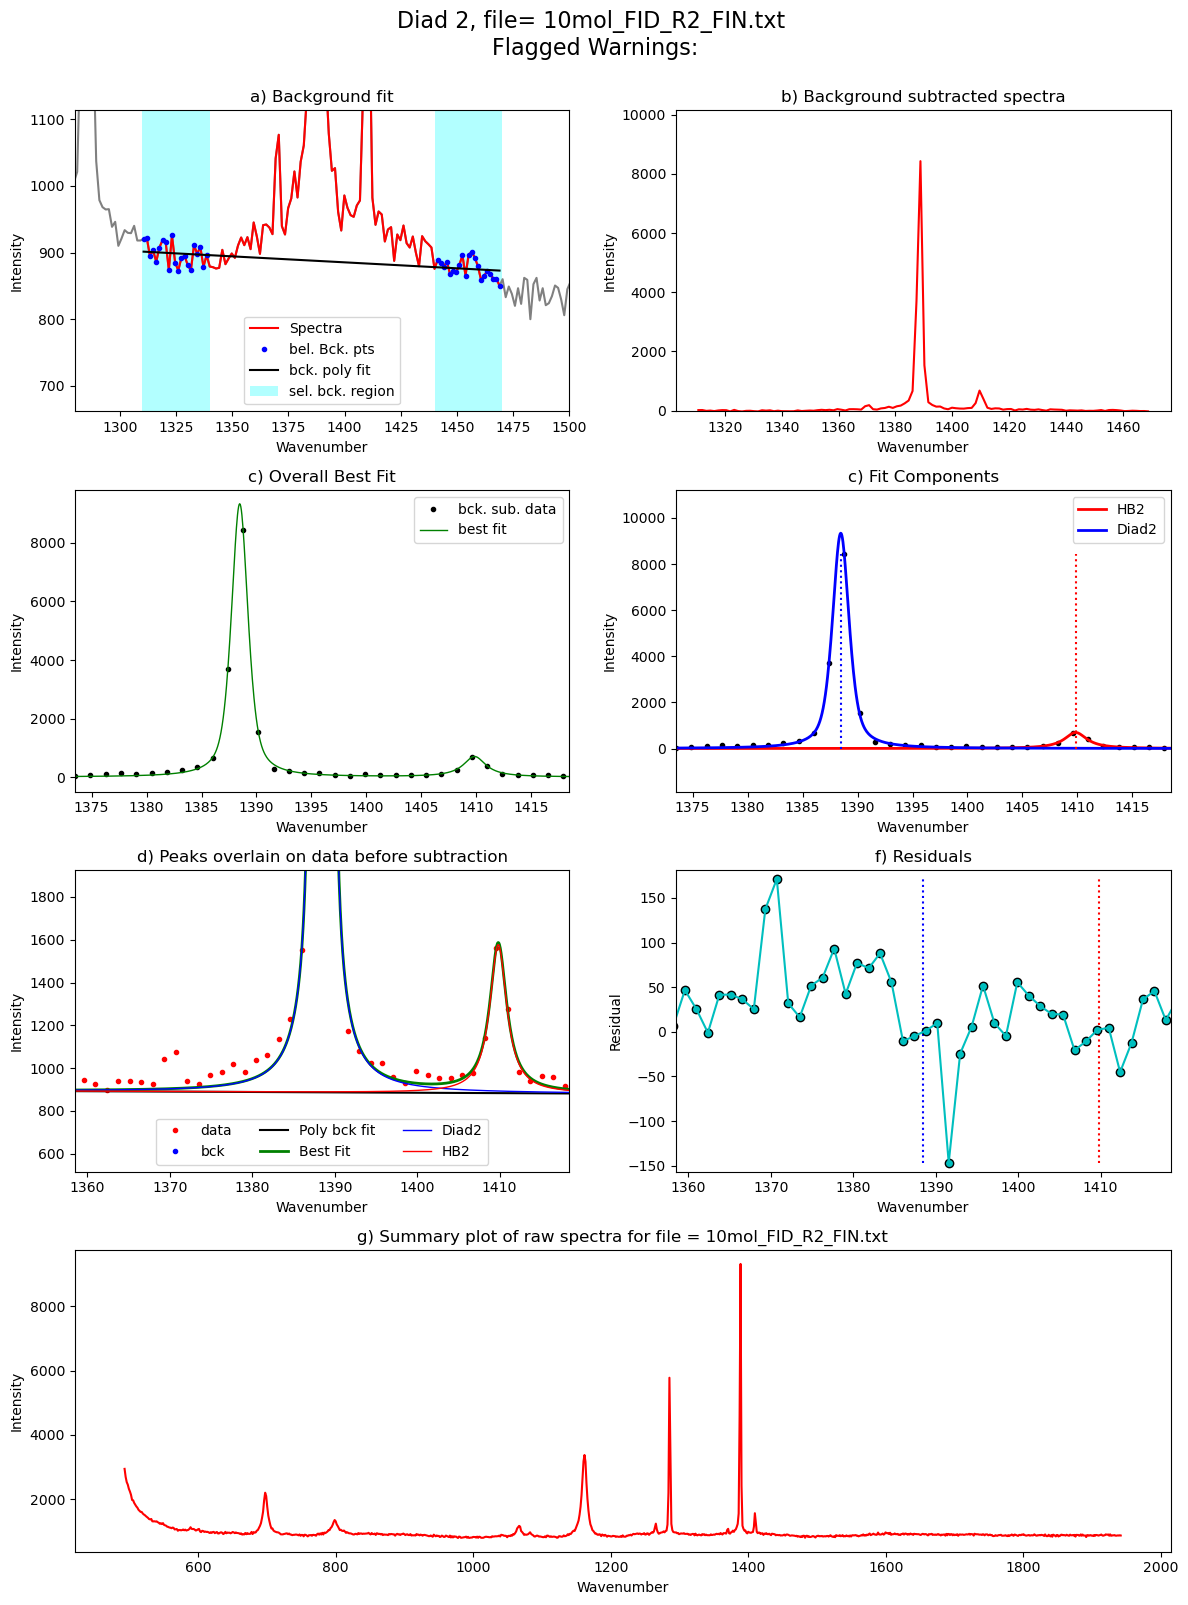

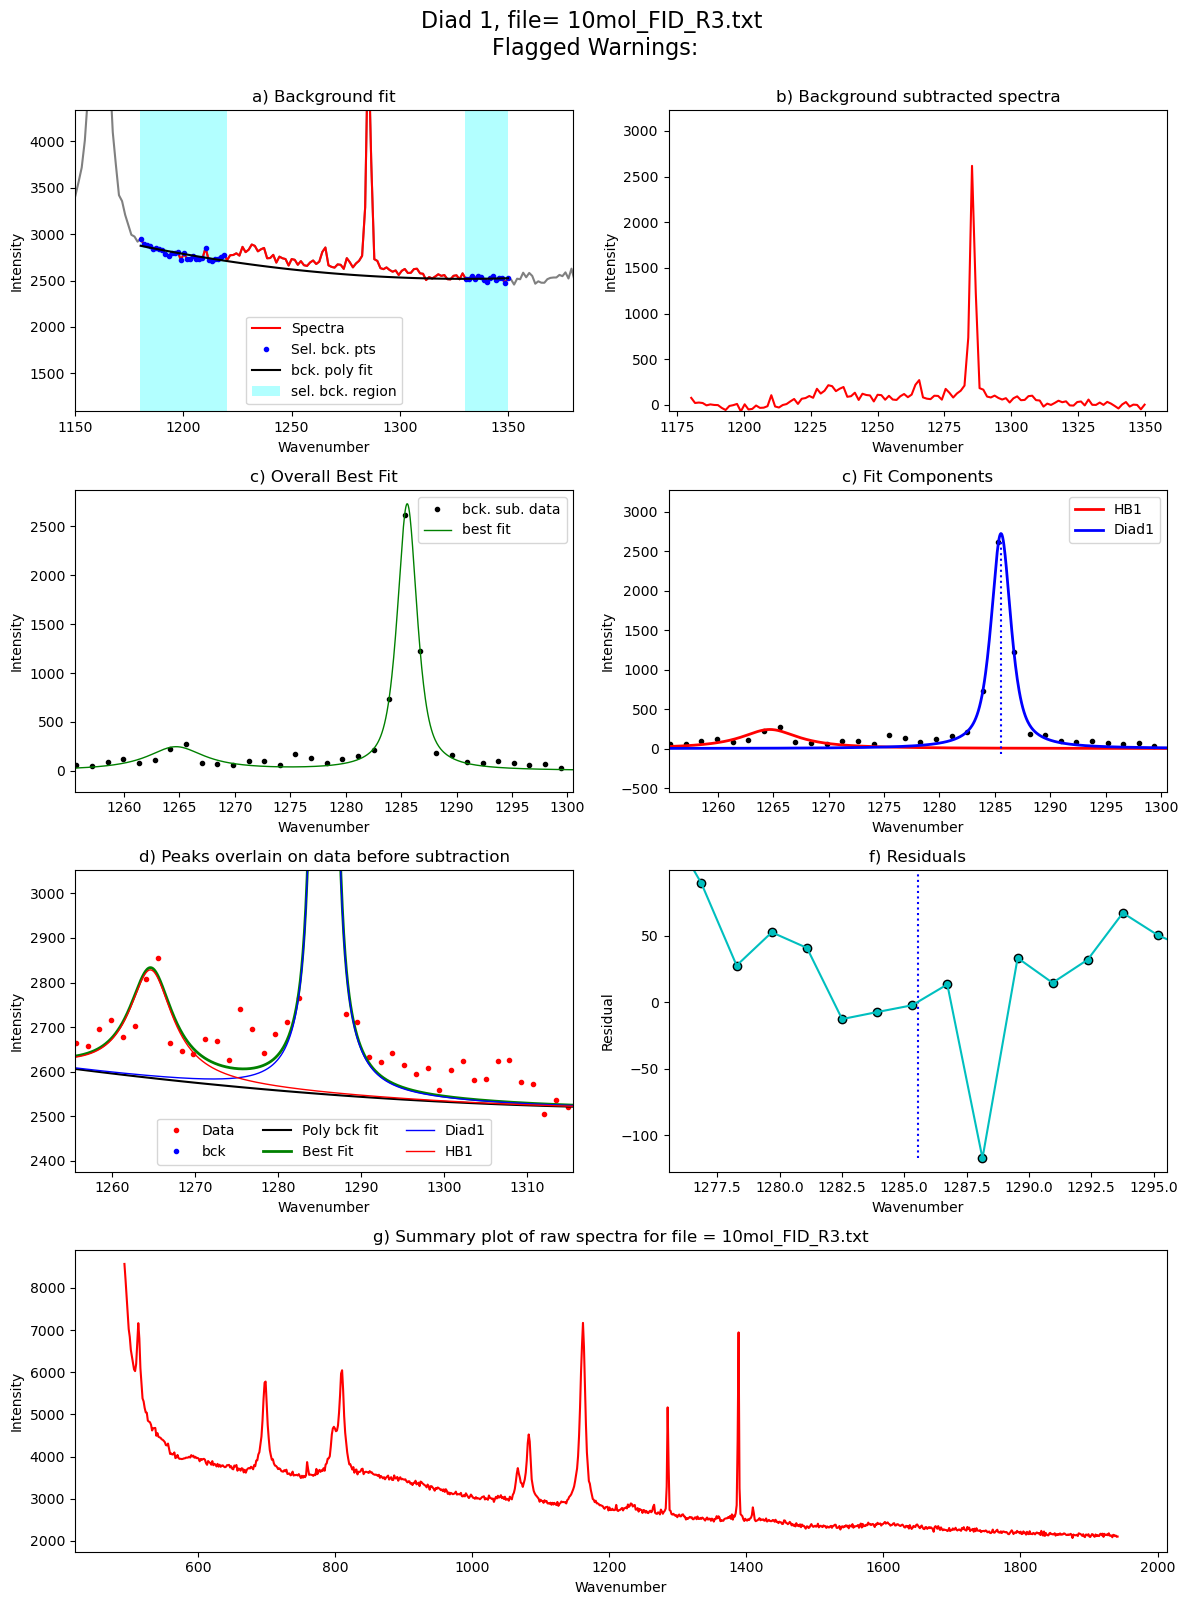

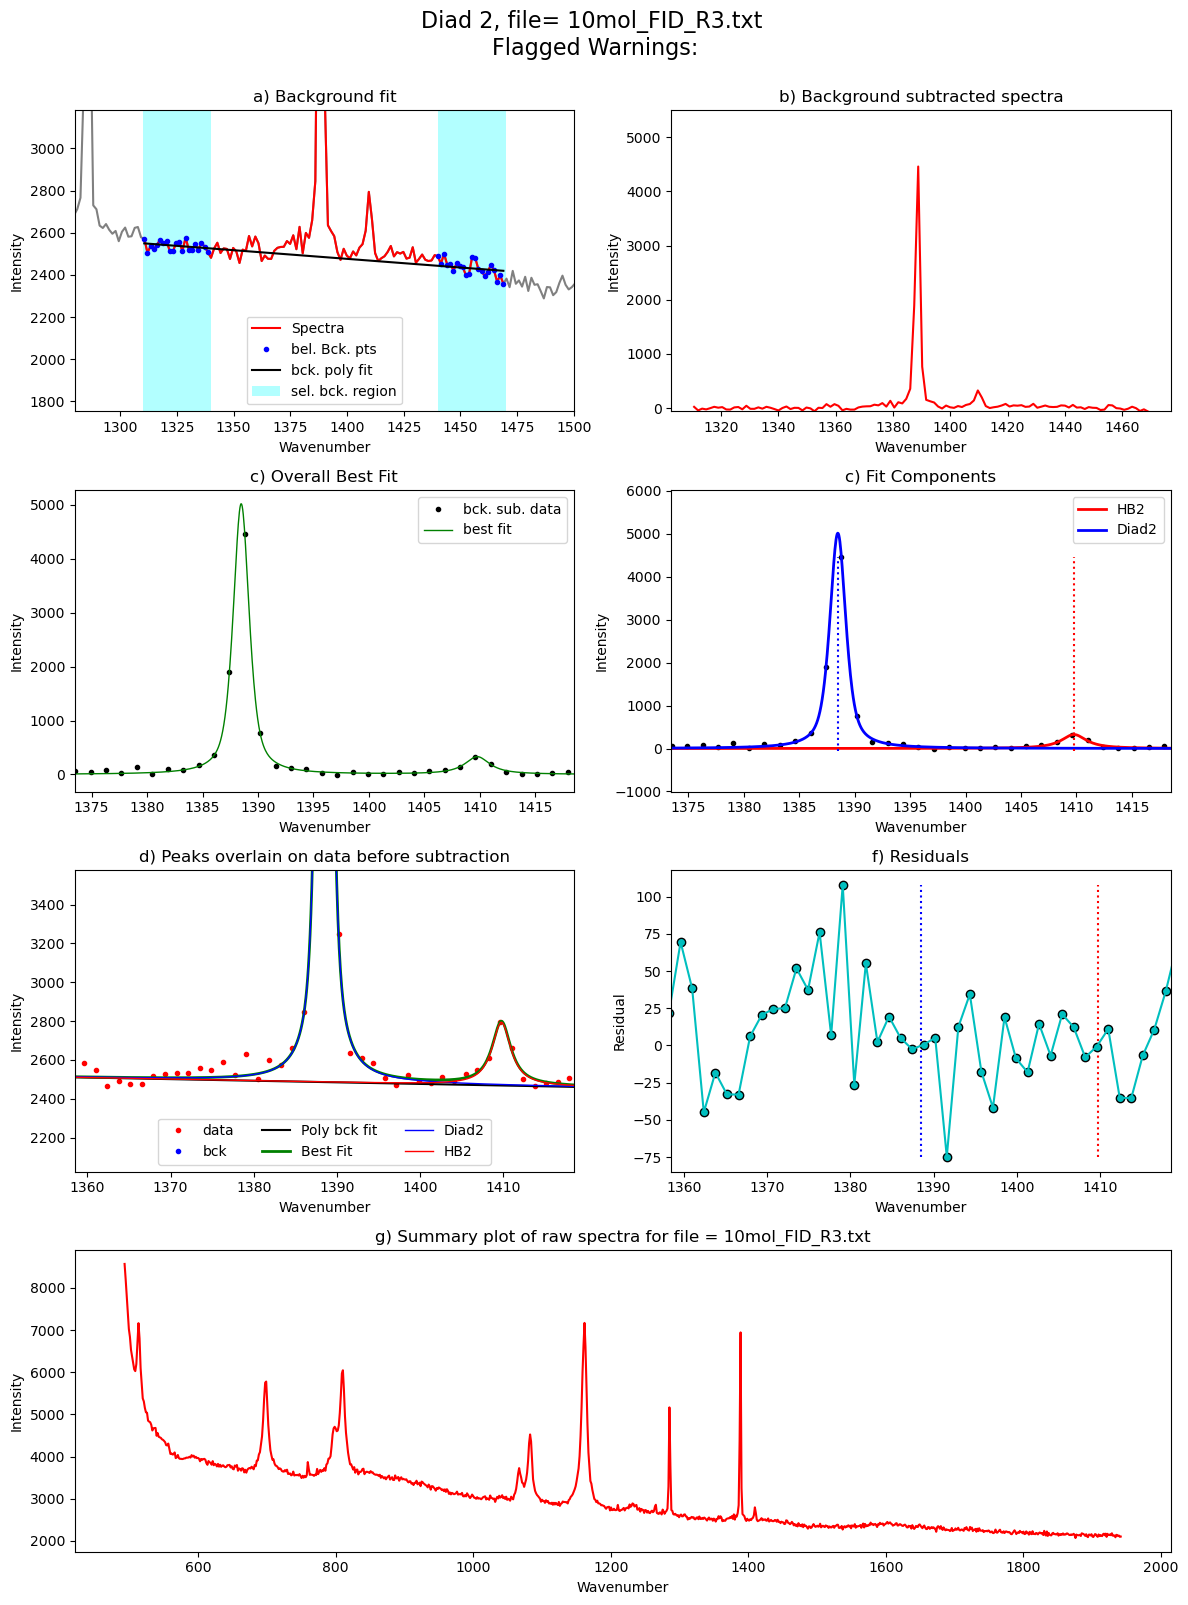

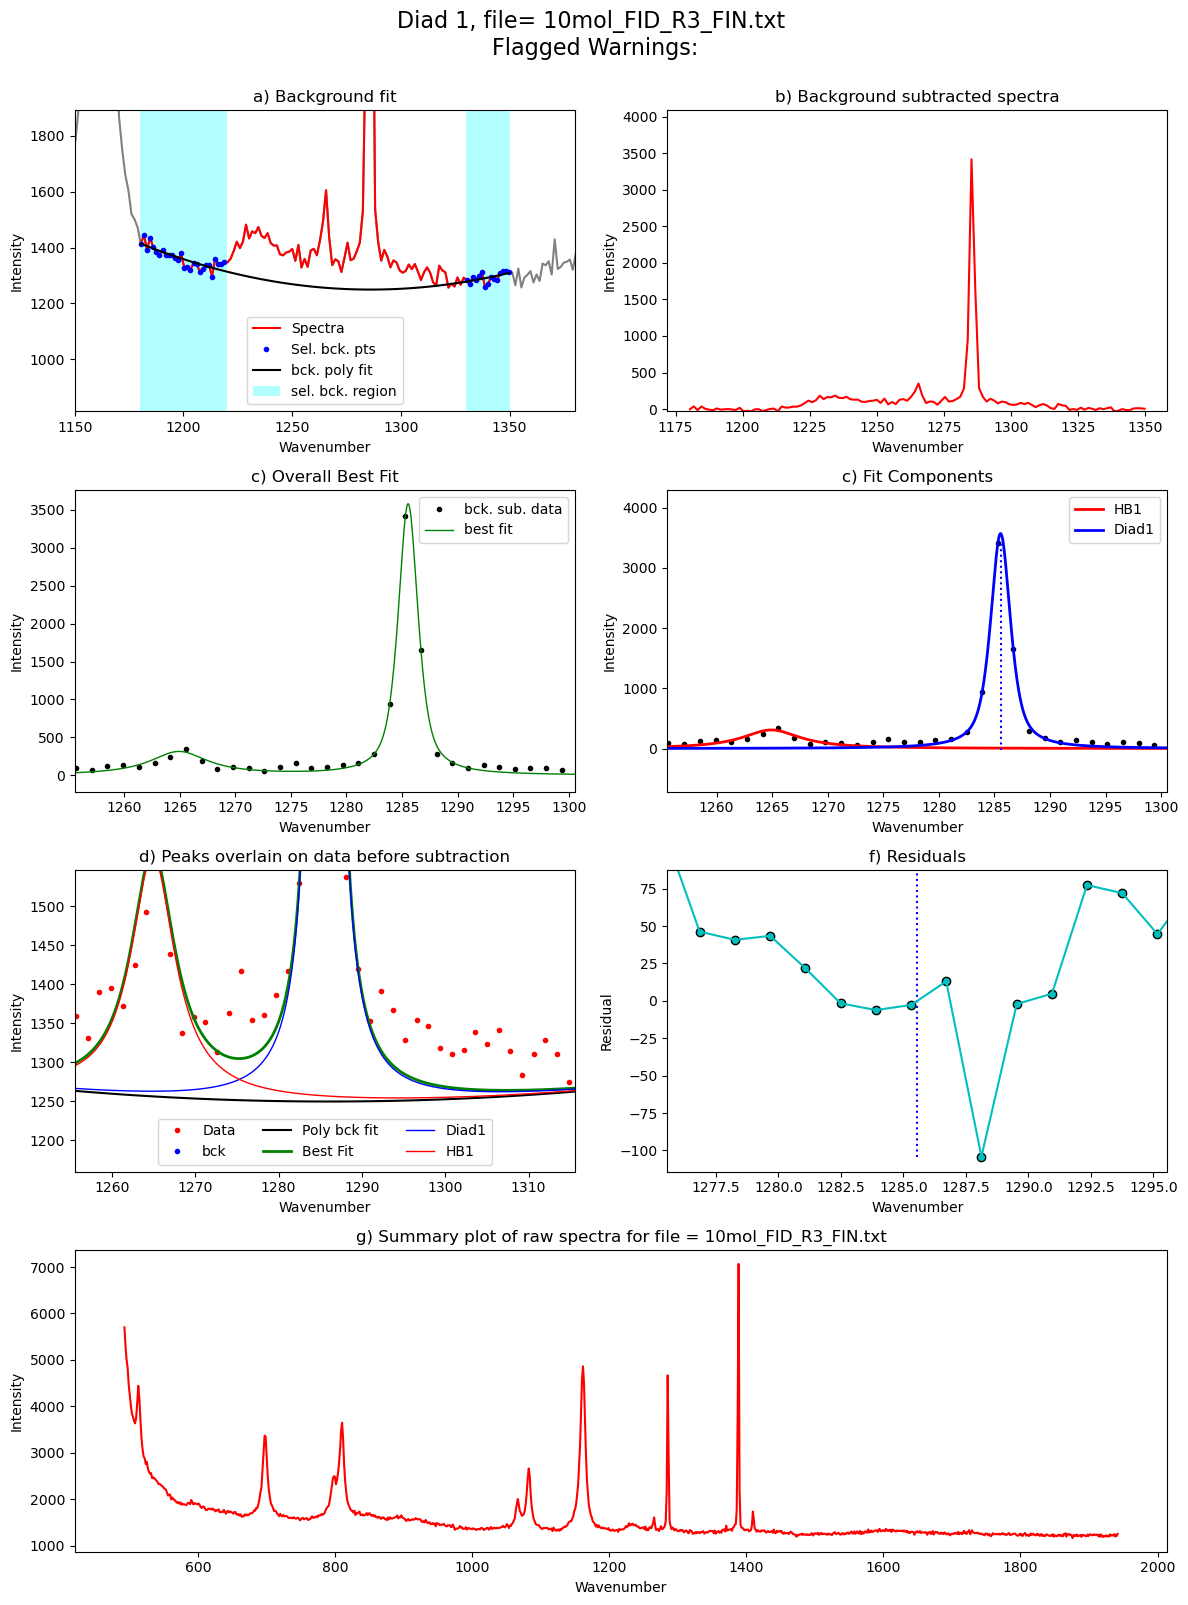

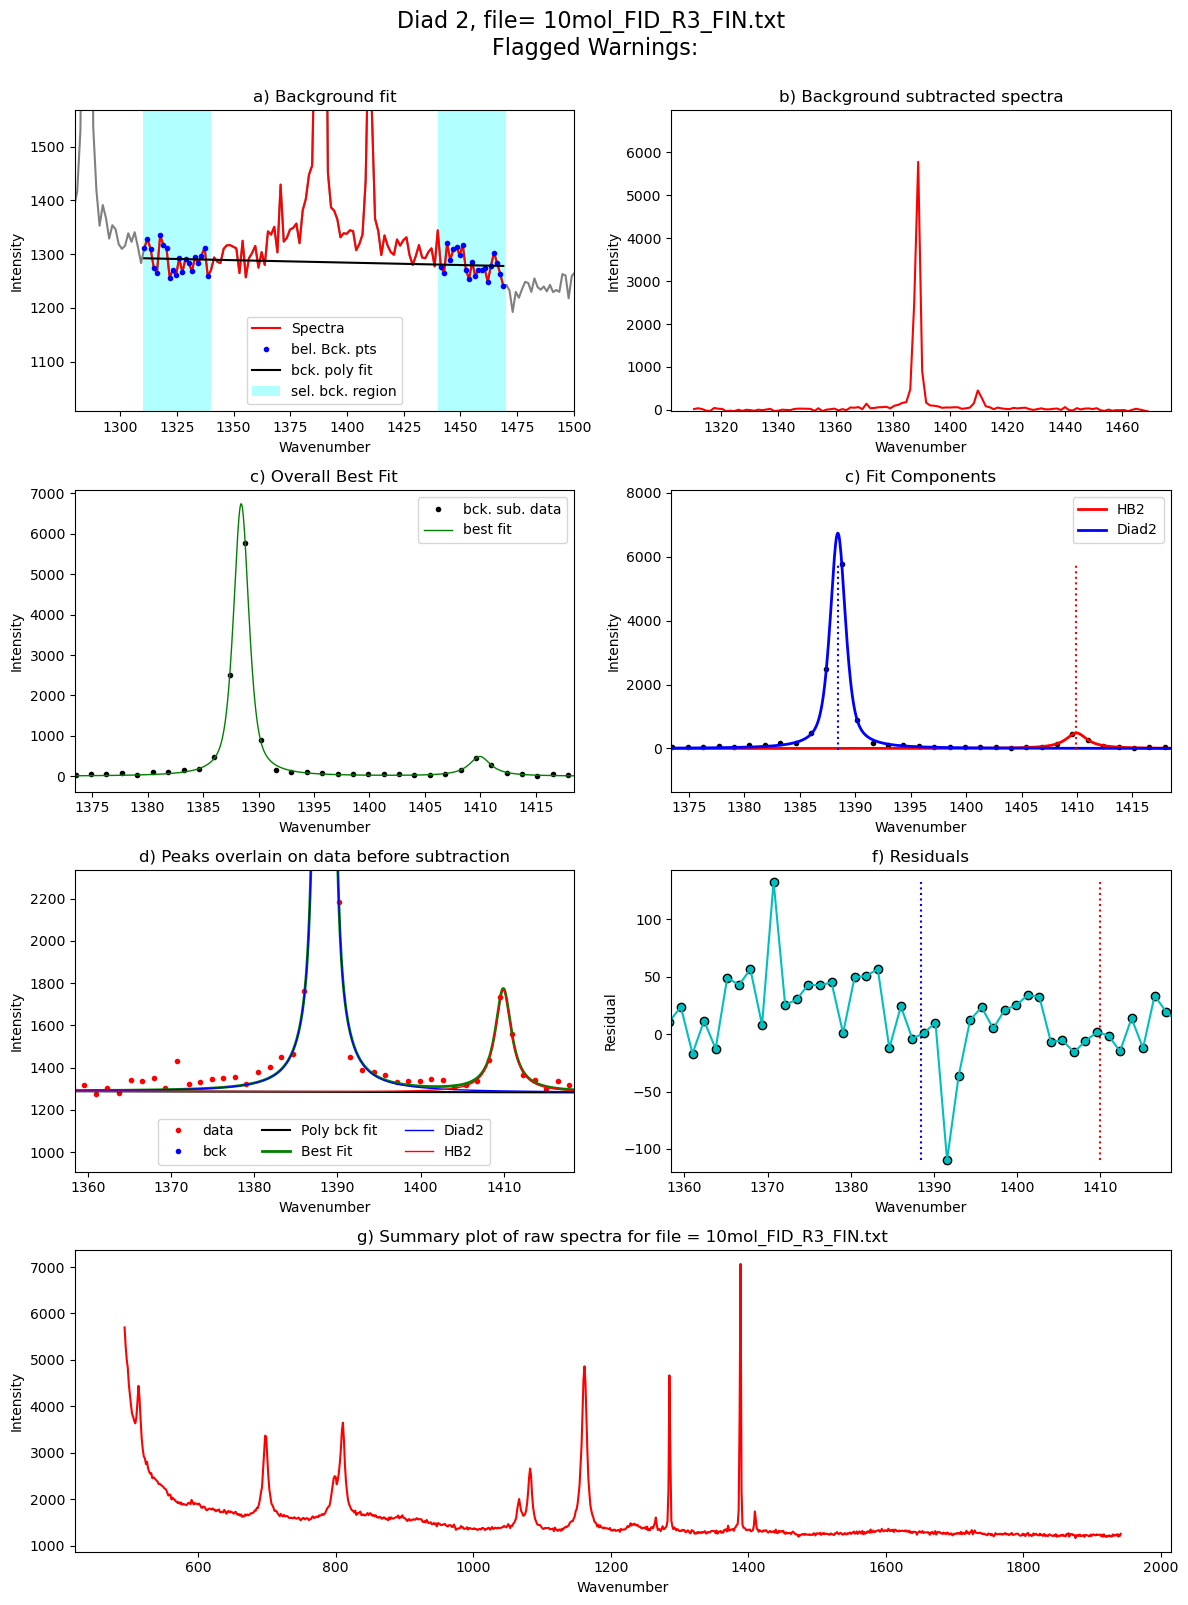

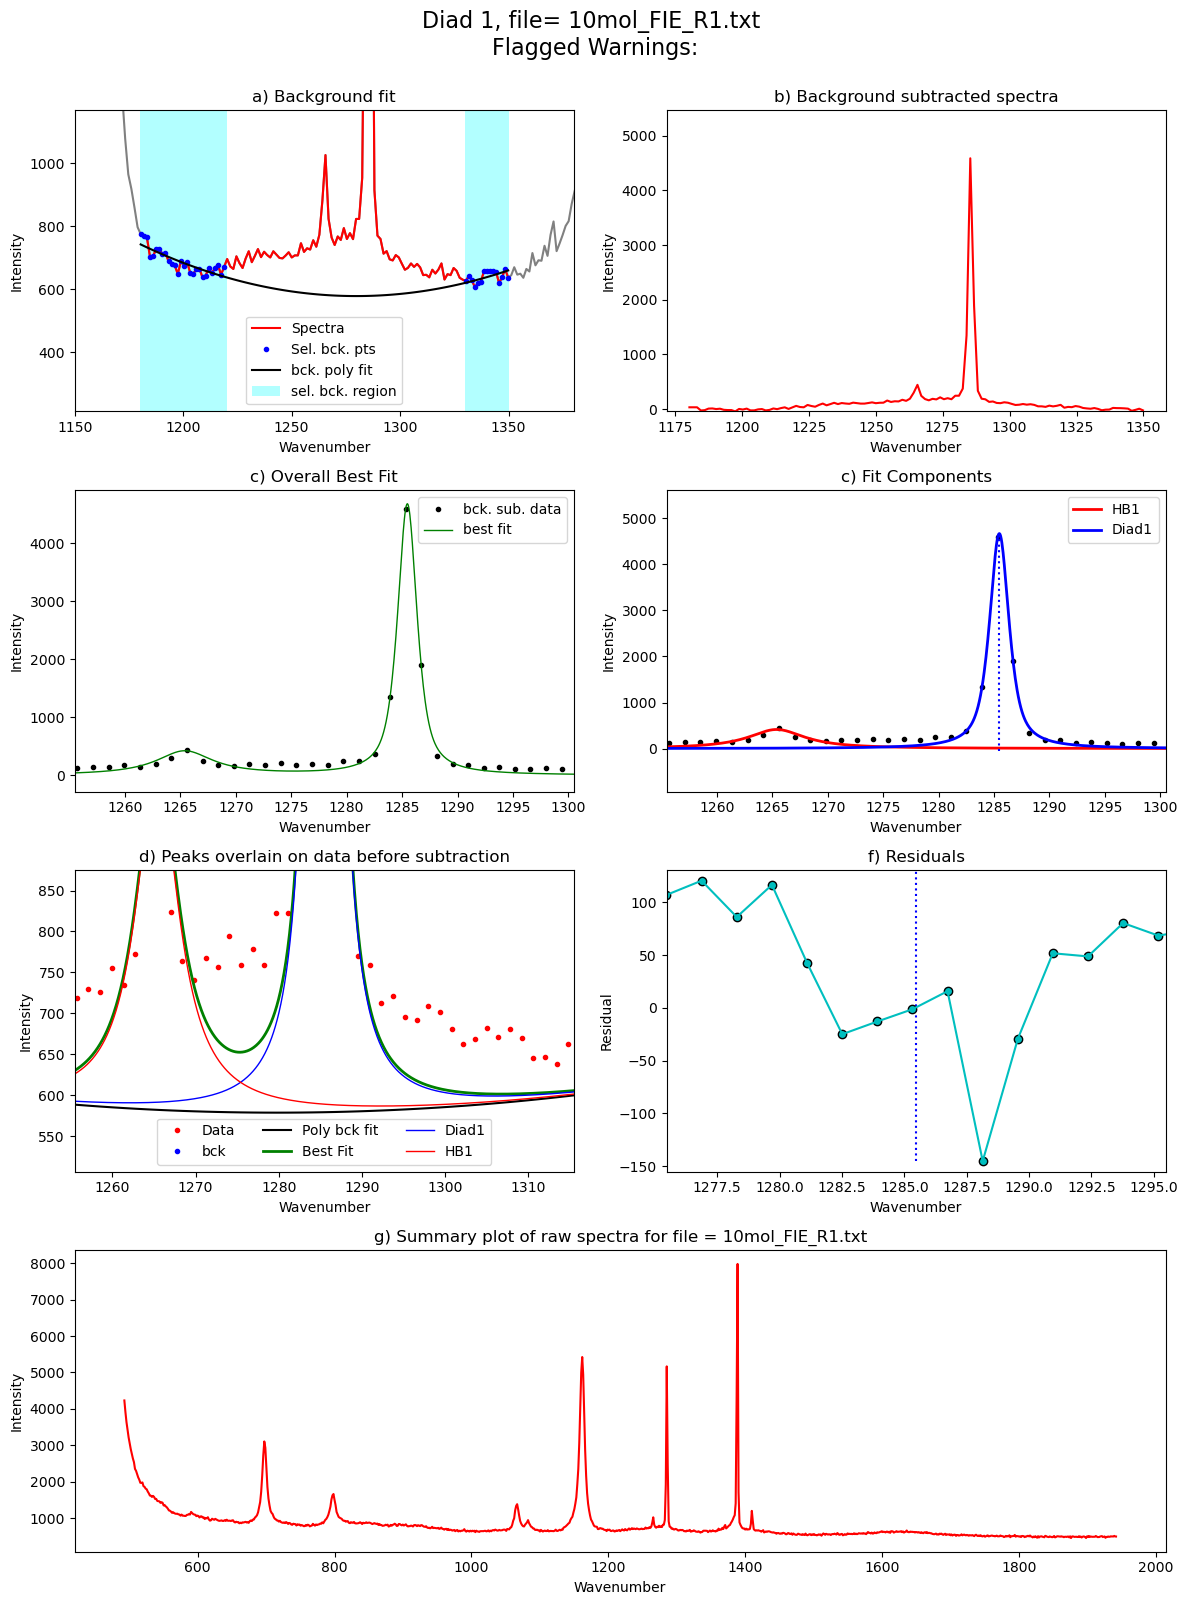

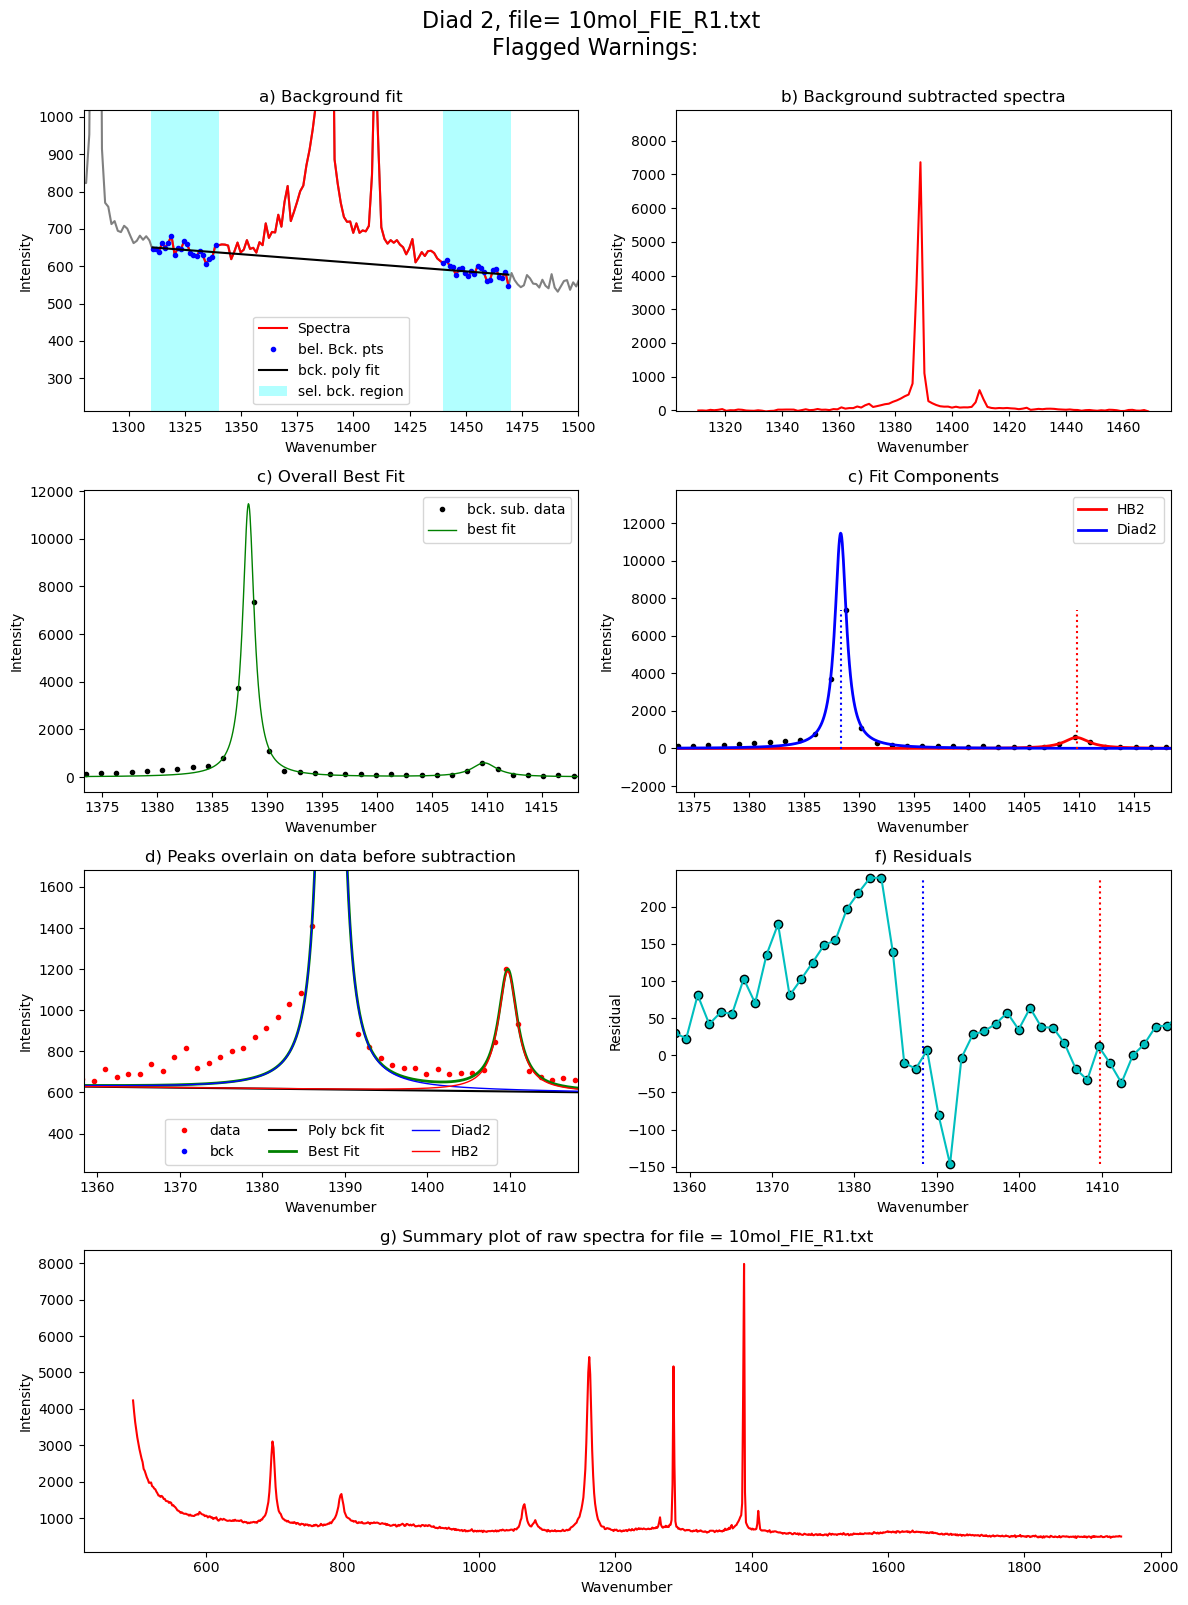

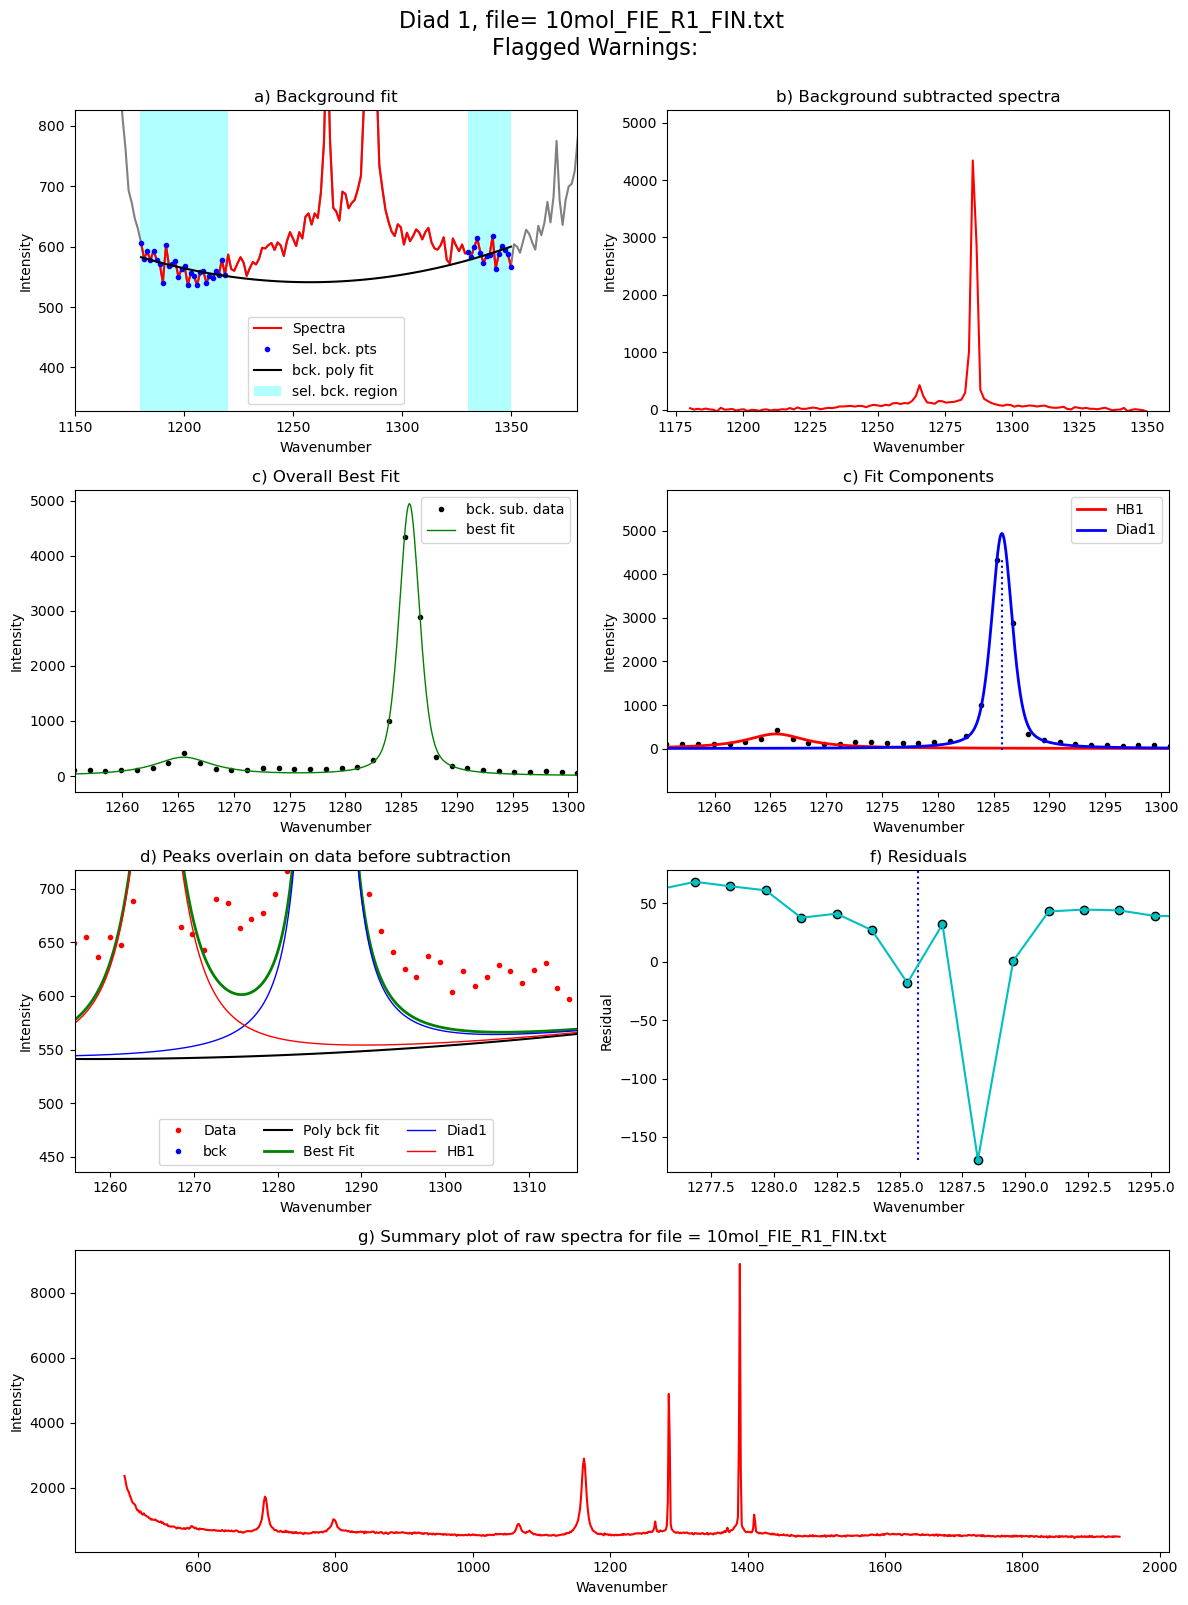

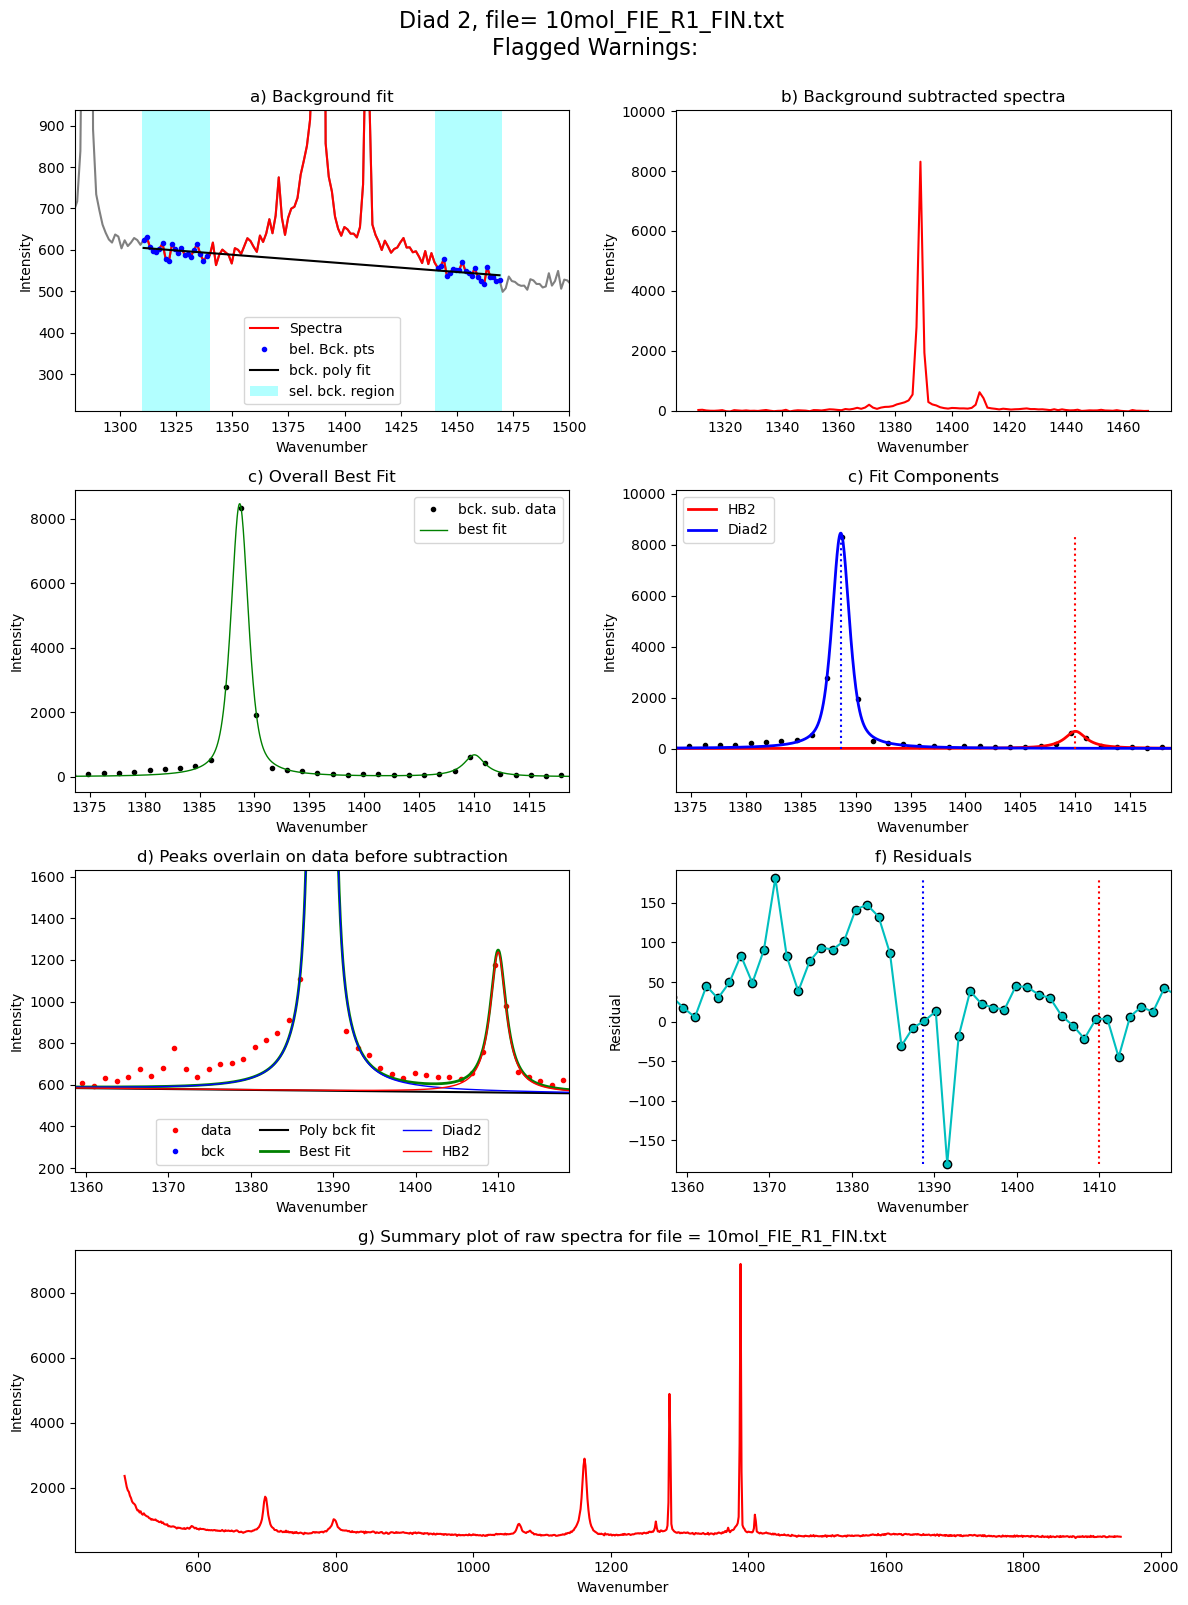

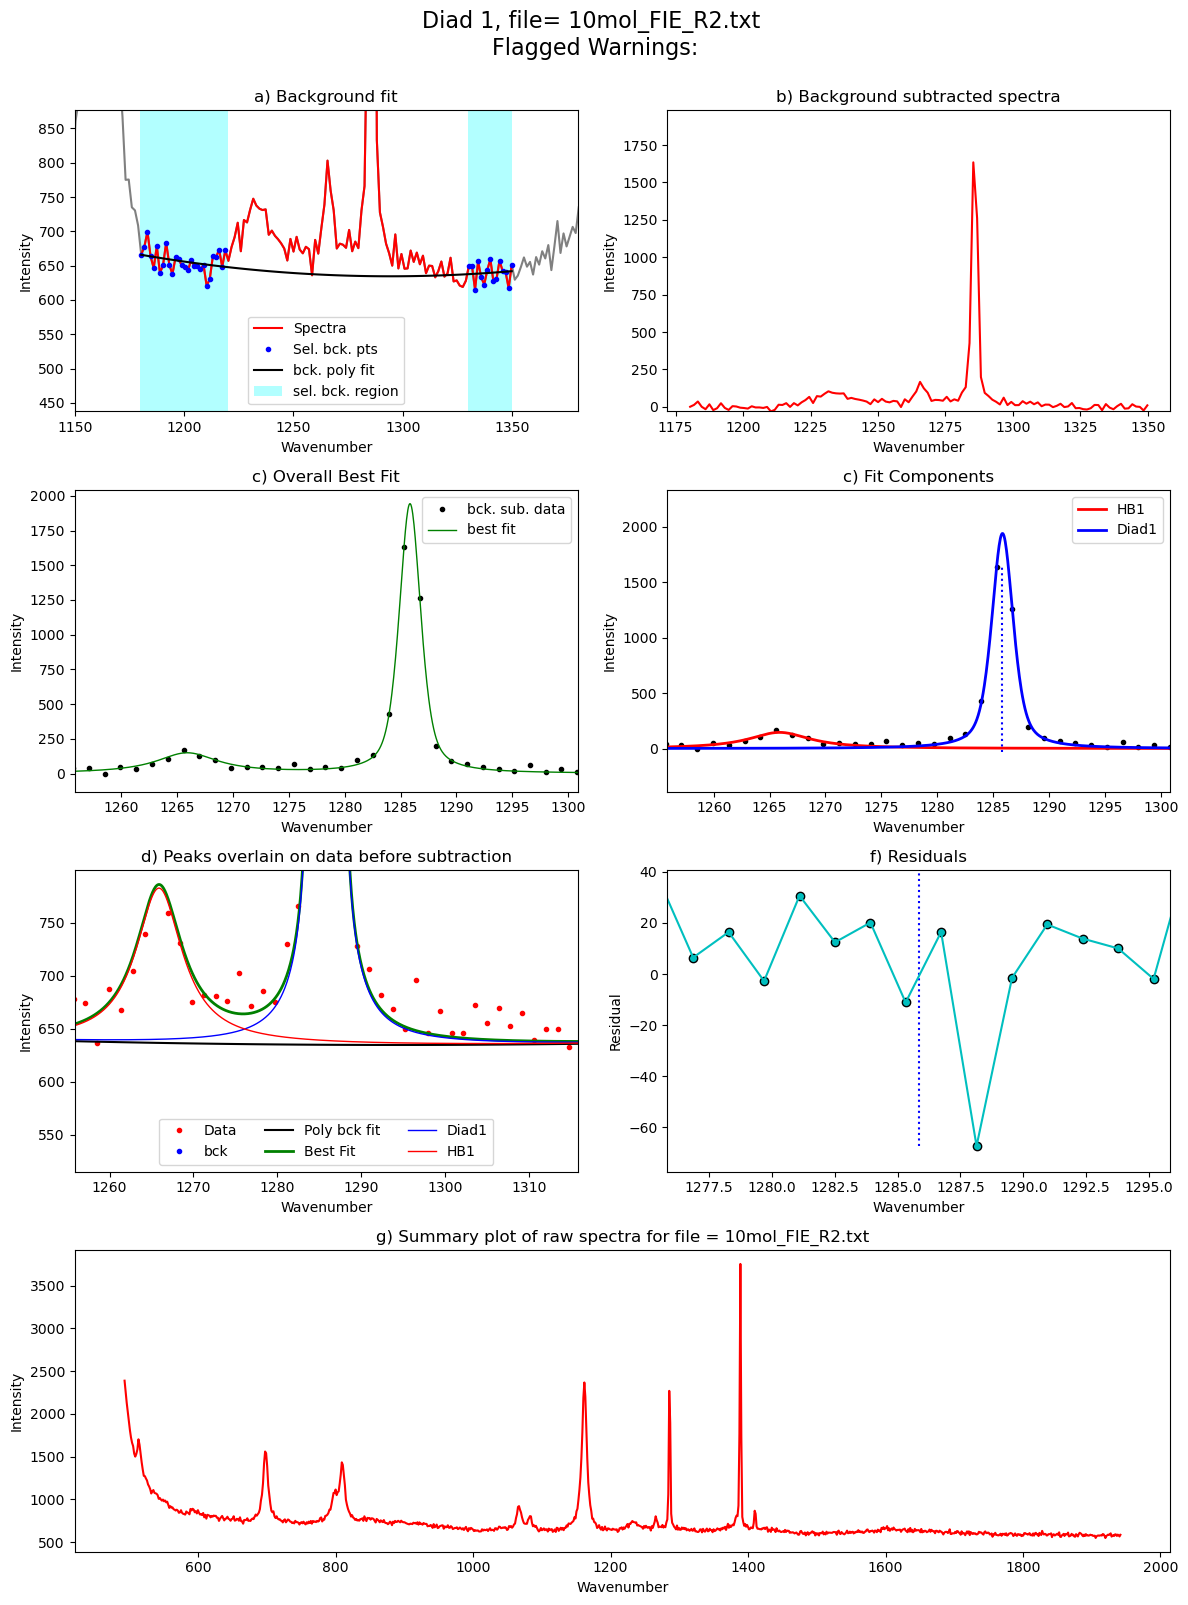

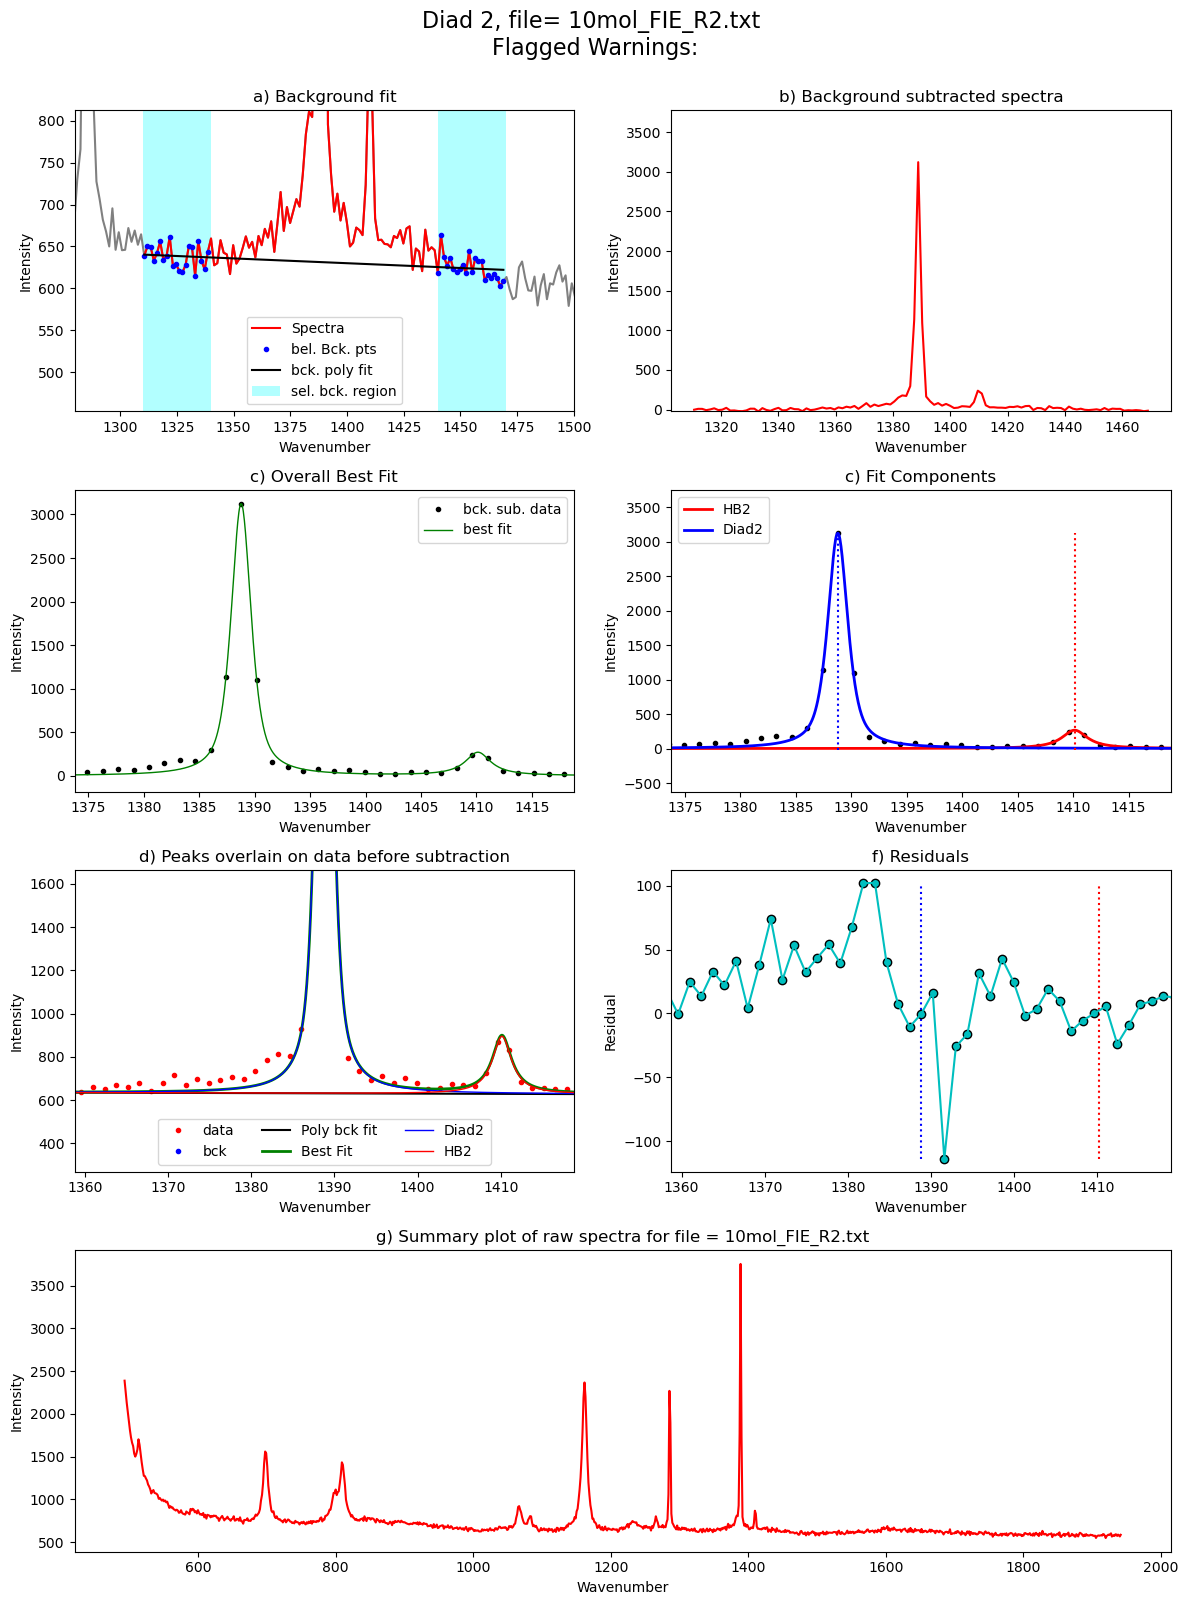

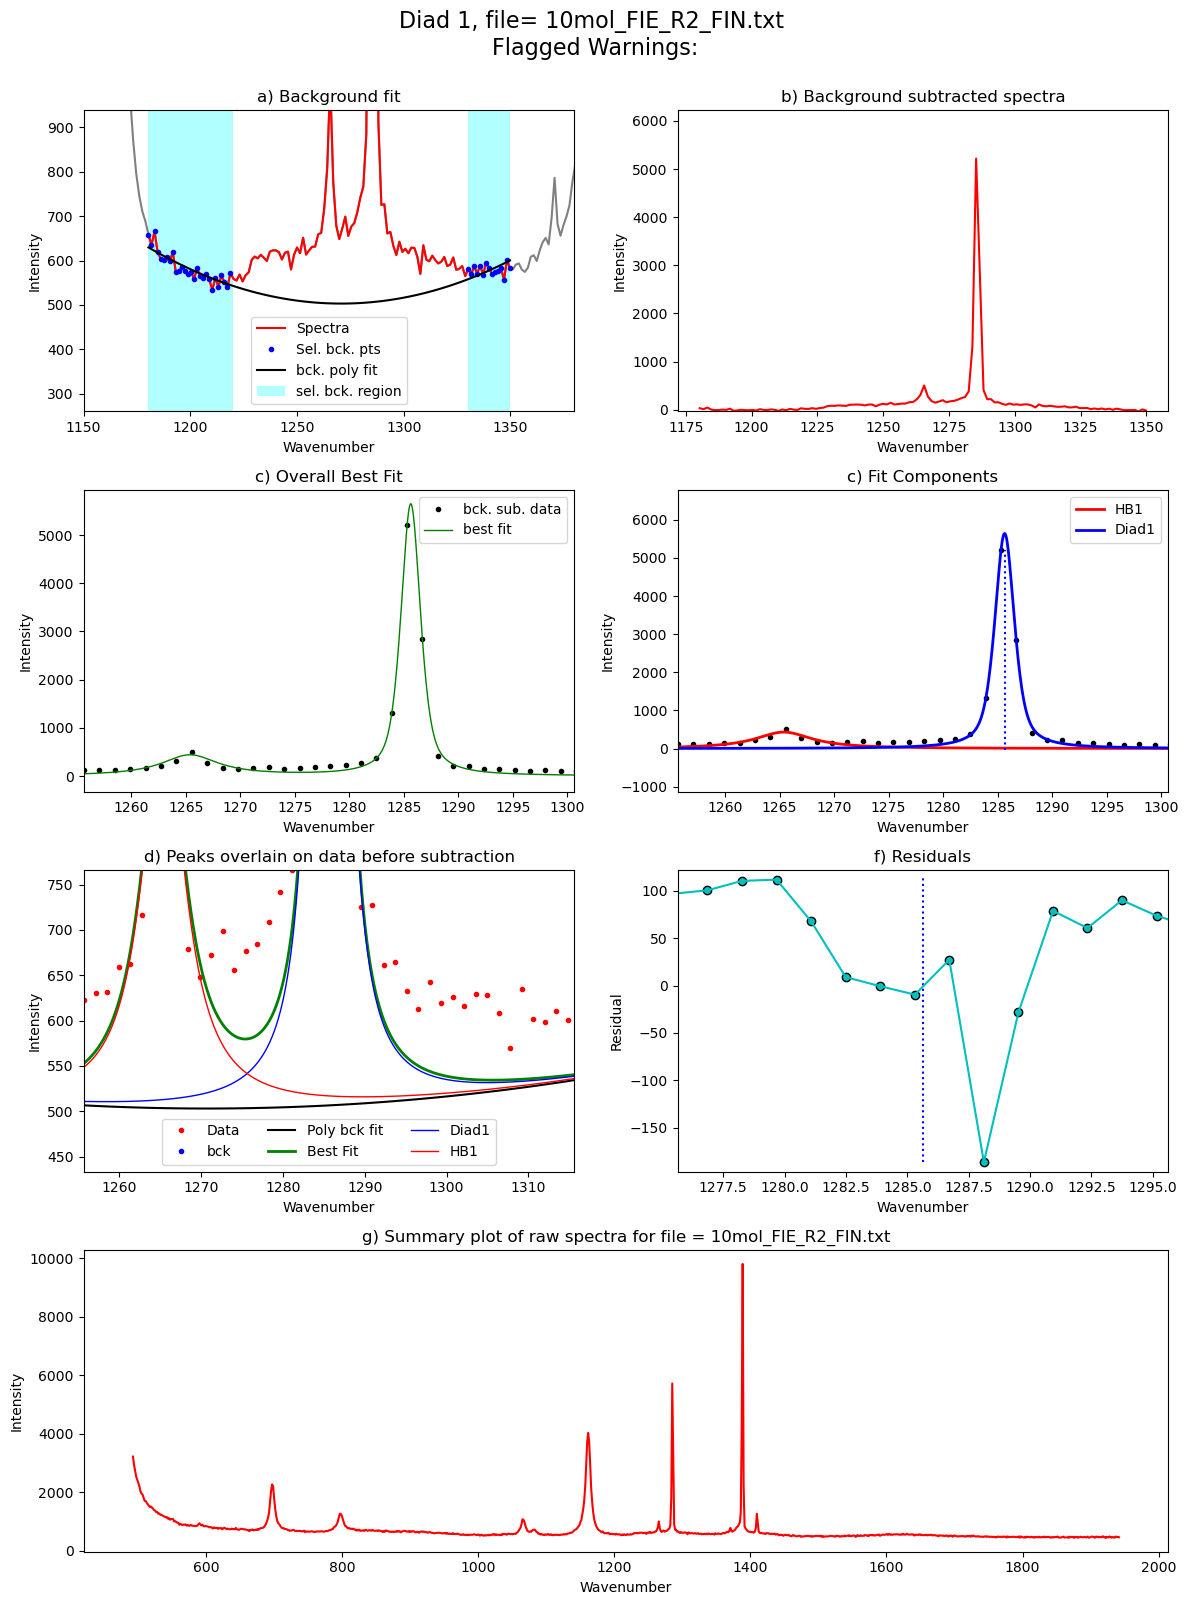

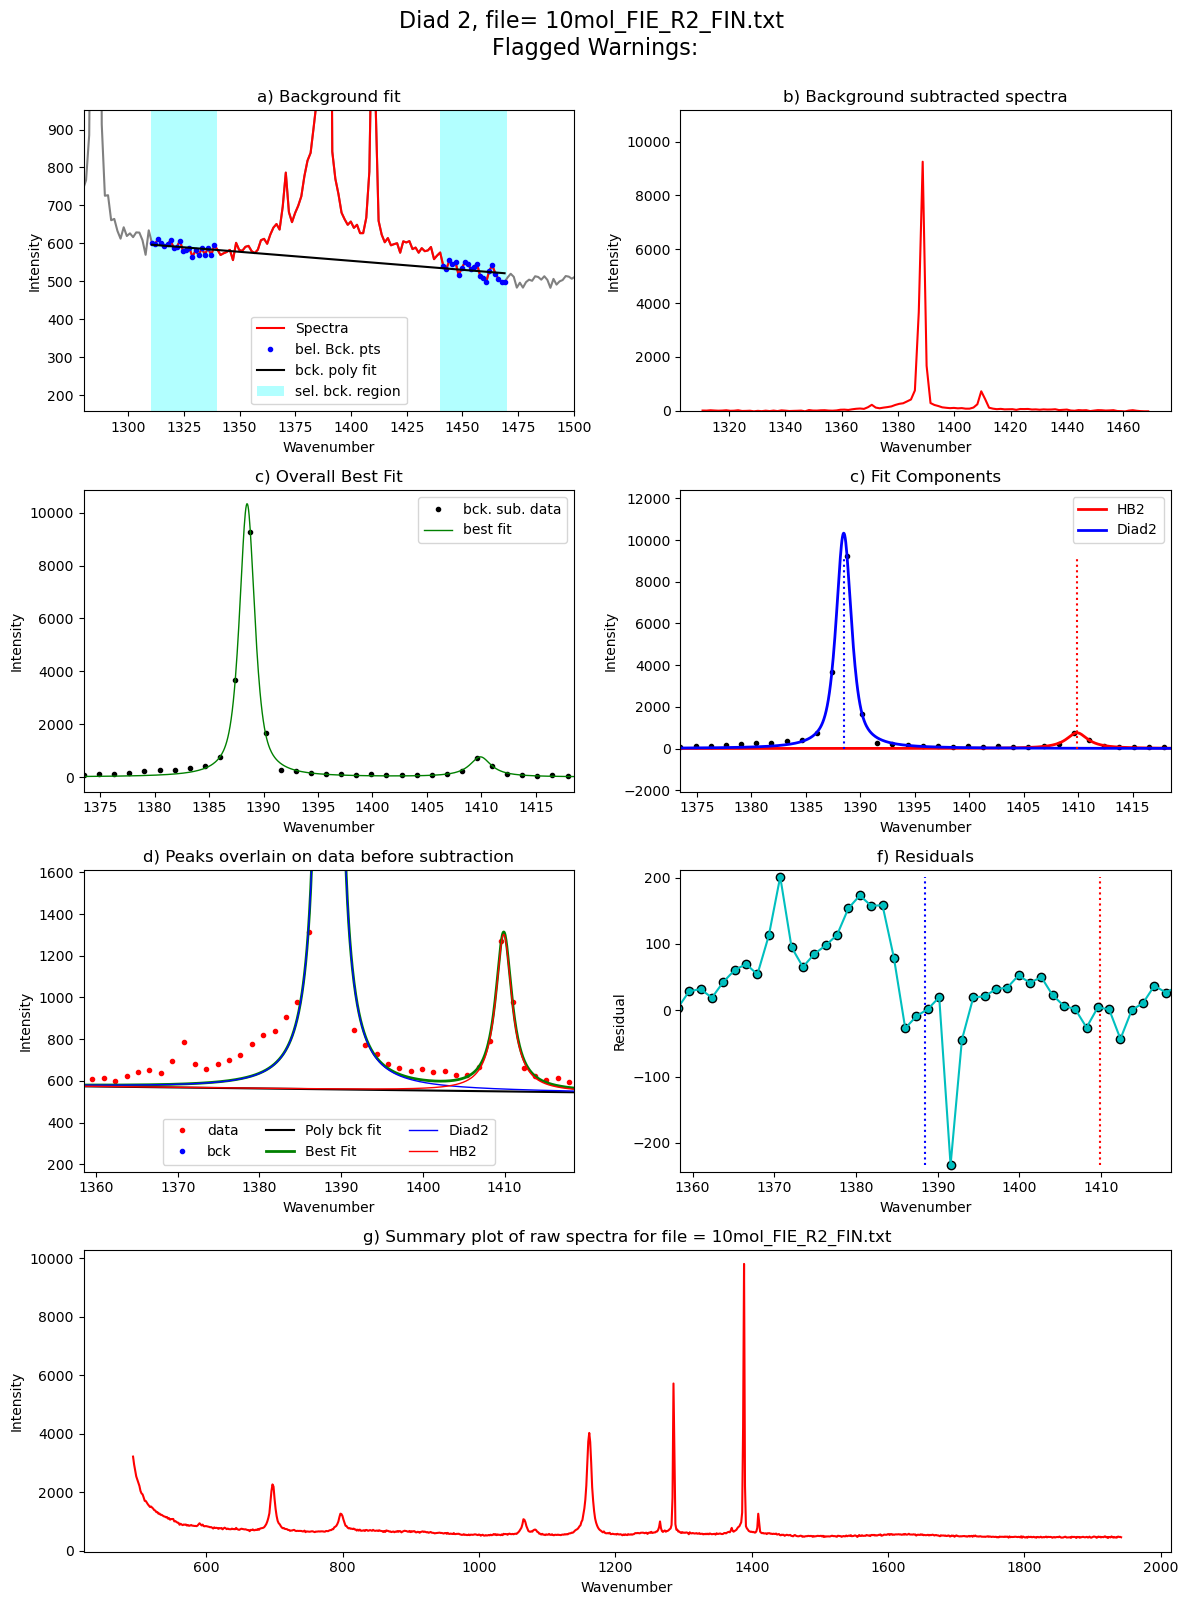

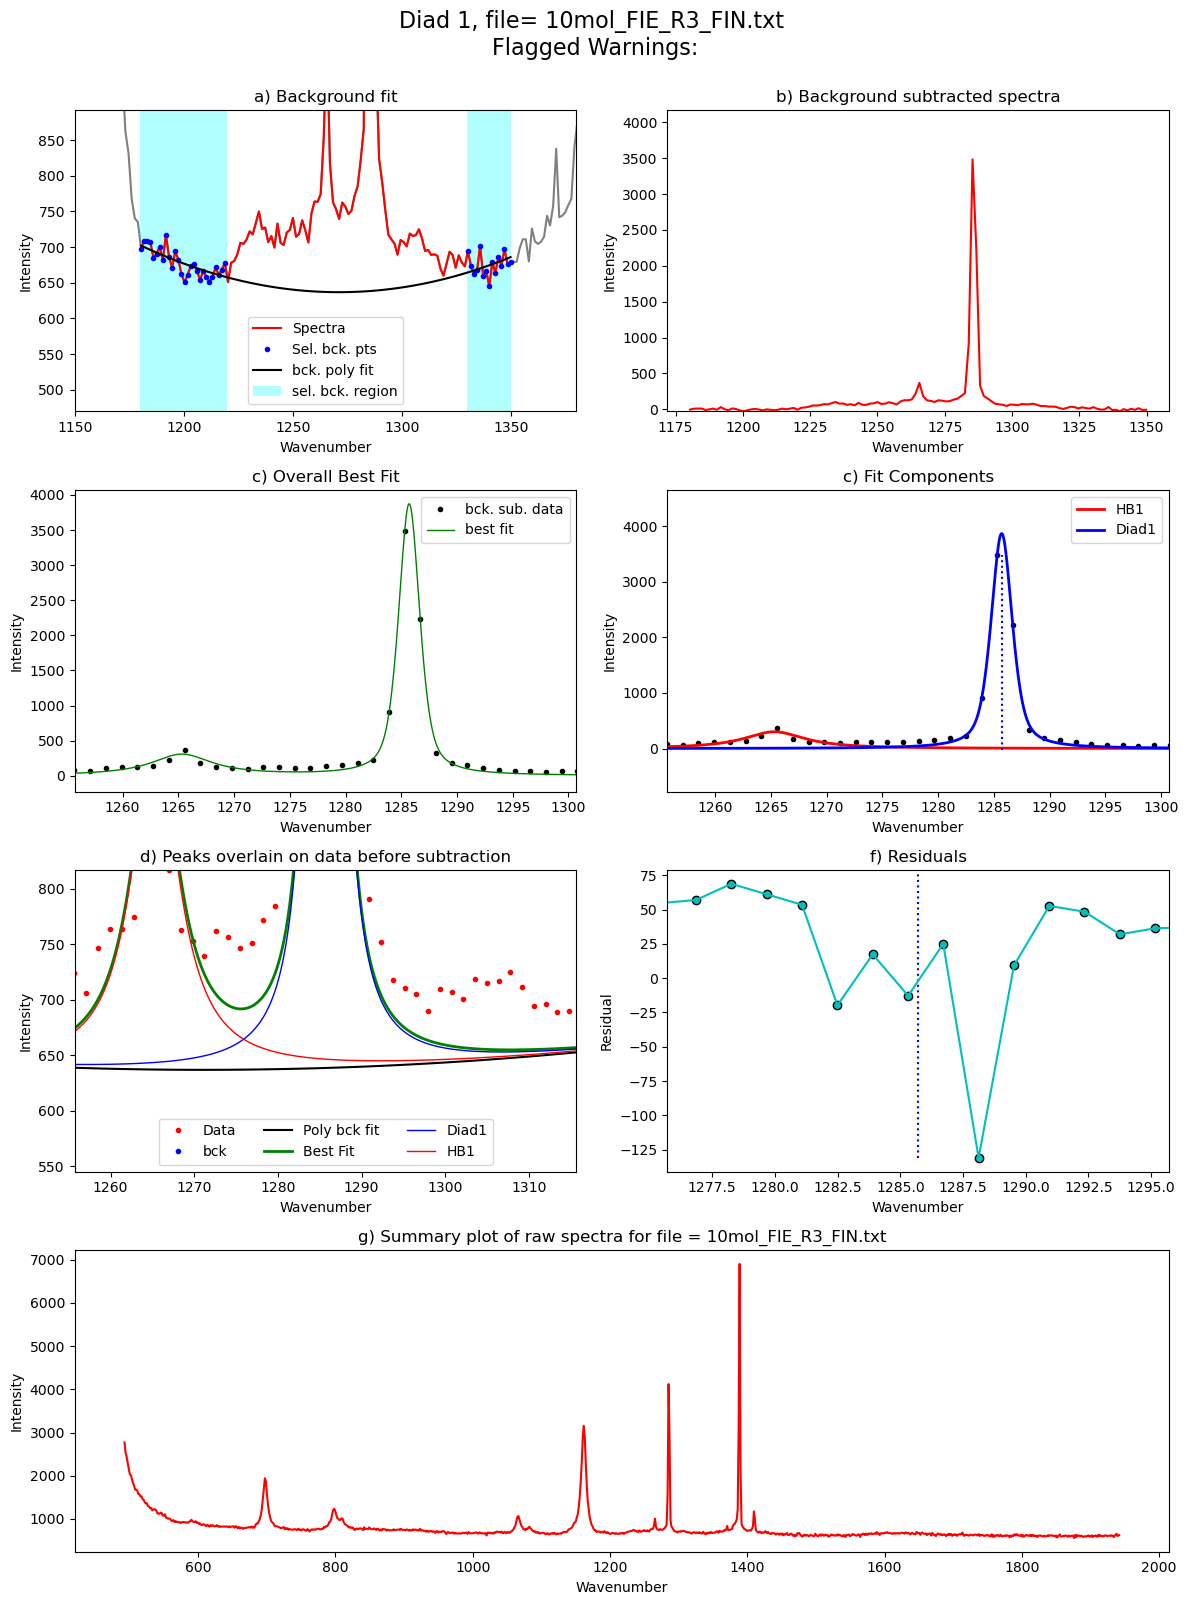

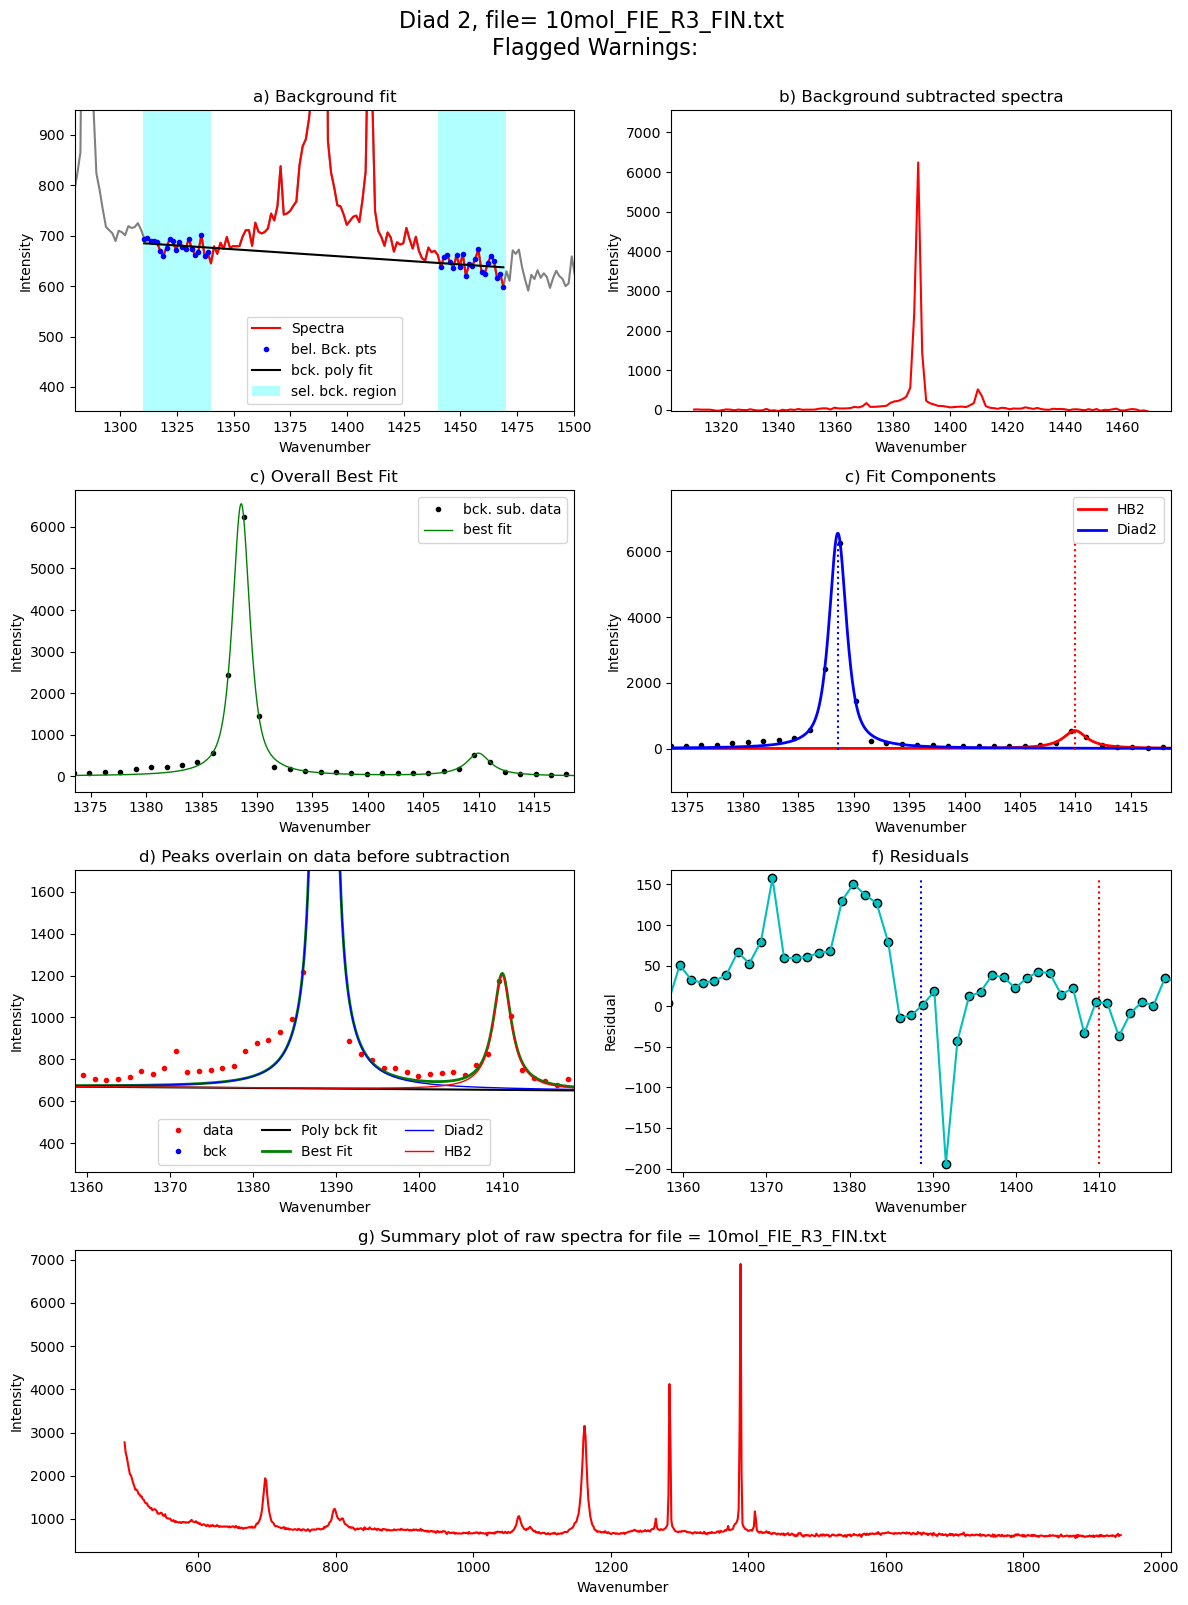

In [50]:
from tqdm import tqdm
plot_figure=True# If False, Means doesnt have to make figures, lot faster. 
close_figure=False # If True, wont show figures in notebook, but will still save them in a folder 
Diad_Files_i=Diad_Files
df_Merge = pd.DataFrame([])
for i in tqdm(range(0, len(Diad_Files))): #
    tqdm.write(f"Processing file: {Diad_Files[i]}")
    
    
    # For diad1, config file like you had in the previous. 
    # Only really used to exclude a range (say your spectra has a known spec)
    diad_id_config=pf.diad_id_config(exclude_range1=[1308, 1309])
    
    # Here, the prominence are taken from the fitting in the last notebook
    diad1_fit_config2.HB_prom=GroupN_df['HB1_abs_prom'].iloc[i]
    diad1_fit_config2.diad_prom=GroupN_df['Diad1_abs_prom'].iloc[i]
    diad1_fit_config2.gauss_amp=2*GroupN_df['HB1_abs_prom'].iloc[i]

    Diad1_fit=pf.fit_diad_1_w_bck(config1=diad1_fit_config2,
    config2=diad_id_config, path=spectra_path, filename=GroupN_df['filename'].iloc[i],
    filetype=filetype, plot_figure=plot_figure, close_figure=close_figure,
    Diad_pos=GroupN_df['Diad1_pos'].iloc[i],
    HB_pos=GroupN_df['HB1_pos'].iloc[i])

    ## Same for diad2, just also has a C13 peak
    diad2_fit_config_init.HB_prom=GroupN_df['HB2_abs_prom'].iloc[i]
    diad2_fit_config_init.diad_prom=GroupN_df['Diad2_abs_prom'].iloc[i]
    diad2_fit_config_init.gauss_amp= 2*GroupN_df['HB2_abs_prom'].iloc[i]
    diad2_fit_config_init.C13_prom=GroupN_df['C13_abs_prom'].iloc[i]
    
    
    Diad2_fit=pf.fit_diad_2_w_bck(config1=diad2_fit_config_init,
        config2=diad_id_config,
    path=spectra_path, filename=GroupN_df['filename'].iloc[i], 
    filetype=filetype,
    plot_figure=plot_figure, close_figure=close_figure,
    Diad_pos=GroupN_df['Diad2_pos'].iloc[i],
    HB_pos=GroupN_df['HB2_pos'].iloc[i], 
    C13_pos=GroupN_df['C13_pos'].iloc[i])
    
    # This combines the outputs into a single dataframe
    data=pf.combine_diad_outputs(filename=GroupN_df['filename'].iloc[i], prefix=prefix, 
    Diad1_fit=Diad1_fit, path=spectra_path,                  
    Diad2_fit=Diad2_fit)        
    
 

    df_Merge = pd.concat([df_Merge, data], axis=0).reset_index(drop=True)


In [51]:
# Save parameters to excel
combo=df_Merge

if batch=='Weak':
    combo.to_excel('Weak_Diads.xlsx', index=False)
if batch=='Medium':
    combo.to_excel('Medium_Diads.xlsx', index=False)
if batch=='Strong':
    combo.to_excel('Strong_Diads.xlsx', index=False)

In [52]:
combo.head()

filename   Splitting   Split_σ  Diad1_Combofit_Cent  \
0      10mol_FID_R1  102.829782  0.050239          1285.534616   
1  10mol_FID_R1_FIN  102.874457  0.021254          1285.528104   
2      10mol_FID_R2  102.854250  0.021455          1285.630145   
3  10mol_FID_R2_FIN  102.895960  0.021071          1285.578507   
4      10mol_FID_R3  102.936253  0.052928          1285.550587   

   Diad1_cent_err  Diad1_Combofit_Height  Diad1_Voigt_Cent  Diad1_Voigt_Area  \
0        0.019256            5704.425730       1285.534766      17339.910923   
1        0.014402            5550.470276       1285.528254      15962.158354   
2        0.017303            4908.770508       1285.630195      14006.842594   
3        0.018386            5218.873864       1285.578657      15691.436906   
4        0.049172            2731.390502       1285.550737       8297.013952   

   Diad1_Voigt_Sigma  Diad1_Residual  ...  HB2_Sigma  C13_Cent C13_Area  \
0           1.101368       63.864080  ...   1.211141       NaN      NaN   
1           1.088765       46.611143  ...   1.208986       NaN      NaN   
2           1.045213       43.528911  ...   1.178481       NaN      NaN   
3           1.108907       57.324032  ...   1.245478       NaN      NaN   
4           1.064871       62.372351  ...   1.363843       NaN      NaN   

   C13_Sigma  Diad2_Gauss_Cent  Diad2_Gauss_Area  Diad2_Gauss_Sigma  \
0        NaN               NaN               NaN                NaN   
1        NaN               NaN               NaN                NaN   
2        NaN               NaN               NaN                NaN   
3        NaN               NaN               NaN                NaN   
4        NaN               NaN               NaN                NaN   

   Diad1_Gauss_Cent  Diad1_Gauss_Area  Diad1_Gauss_Sigma  
0               NaN               NaN                NaN  
1               NaN               NaN                NaN  
2               NaN               NaN                NaN  
3               NaN               NaN                NaN  
4               NaN               NaN                NaN  

[5 rows x 39 columns]